In [1]:
## loading package 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import pylab
import seaborn as sns 
from sklearn.metrics.pairwise import cosine_similarity
from statannot import add_stat_annotation
import matplotlib as mpl
from scipy import stats, cluster
import glob
import re
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats import multitest
from matplotlib.gridspec import GridSpec

from matplotlib_venn import venn2, venn3
from matplotlib import pyplot as plt

import time
from scipy.stats.mstats import winsorize

import warnings 
warnings.simplefilter('ignore')

## load_large_dataFrame
def load_large_dataFrame(input_file, sep=",", header=0, index_col=0, chunksize=100000, compressed=False):
    if compressed:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col, compression='gzip')
    else:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col)
    dfList=[]
    for df in TextFileReader:
        dfList.append(df)
    final_df = pd.concat(dfList,sort=False)
    return final_df

# Mutant Rate to Reactivity

## 0. Functions

In [2]:
## calculate reactivity from mutant rate matrix
###    1) NAI-N3 - AVG(DMSO)
def calculate_reactivity_from_mutrate(mutrate_df):
    mutrate_df_dmso = mutrate_df.xs("dmso", level="agent", axis=1).mean(axis=1).to_frame('dmso.reac.mean')
    mutrate_df_nai = mutrate_df.xs("nai-n3", level="agent", axis=1)
    ## substract to dmso mean reac 
    dmso_matrix = pd.concat([mutrate_df_dmso]*mutrate_df_nai.columns.size, axis=1)
    dmso_matrix.columns = mutrate_df_nai.columns
    crude_reac = mutrate_df_nai - dmso_matrix
    crude_reac.sort_index(inplace=True)
    return crude_reac
def iterate_batch_stages_for_reactivity_from_mutrate_matrix(mutrate_df):
    #print (mutrate_df)
    concat_list = []
    for [batch, stage, lib_type], stage_mutrate_df in mutrate_df.groupby(['batch','stage','lib_type'], axis=1):
        stage_crude_reac = calculate_reactivity_from_mutrate(stage_mutrate_df)
        concat_list.append(stage_crude_reac)
    crude_reac = pd.concat(concat_list, axis=1)
    return crude_reac

def calculate_reactivity_from_mutrate_subtract_to_same_DMSO(mutrate_df, dmso_lib_type="single"):
    mutrate_df_dmso = mutrate_df.xs("dmso", level="agent", axis=1)
    mutrate_df_dmso = mutrate_df_dmso.xs(dmso_lib_type, level="lib_type", axis=1).mean(axis=1).to_frame('dmso.reac.mean')
    mutrate_df_nai = mutrate_df.xs("nai-n3", level="agent", axis=1)
    ## substract to dmso mean reac 
    dmso_matrix = pd.concat([mutrate_df_dmso]*mutrate_df_nai.columns.size, axis=1)
    dmso_matrix.columns = mutrate_df_nai.columns
    crude_reac = mutrate_df_nai - dmso_matrix
    crude_reac.sort_index(inplace=True)
    return crude_reac

In [3]:
def gene_normalization_1nt(crude_reac, bottom_winsorize=0.0, top_winsorize=0.0, transcriptome_winsorize=False, gene_winsorize=False):
    
    ## transcriptome-wide winsorization
    crude_reac_array = crude_reac.to_numpy()
    if transcriptome_winsorize:
        crude_reac_array = winsorize(crude_reac_array, limits=[bottom_winsorize, top_winsorize], axis=0, nan_policy="omit")
    winsorized_reac = pd.DataFrame(crude_reac_array, index=crude_reac.index, columns=crude_reac.columns)
    
    concat_genes = []
    for gene, gene_crude_reac in winsorized_reac.groupby(level="gene"):
        ## gene winsorization
        crude_reac_array = gene_crude_reac.to_numpy()
        if gene_winsorize:
            crude_reac_array = winsorize(crude_reac_array, limits=[bottom_winsorize, top_winsorize], axis=0, nan_policy="omit")
        gene_winsorized_reac = pd.DataFrame(crude_reac_array, index=gene_crude_reac.index, columns=gene_crude_reac.columns)
   
        concat_stages = []
        for stage, stage_crude_reac in gene_winsorized_reac.items():
            
            
            iqr = stats.iqr(stage_crude_reac)
            if stage_crude_reac.index.size >= 200:
                pct95_val = np.nanpercentile(stage_crude_reac, 95)
            else:
                pct95_val = np.nanpercentile(stage_crude_reac, 90)
            # filter_outlies_series = stage_crude_reac.loc[stage_crude_reac < max(pct95_val, 1.5*iqr)]
            filter_outlies_series = stage_crude_reac.loc[stage_crude_reac < min(pct95_val, 1.5*iqr)]
            pct90_val_filtered = np.nanpercentile(filter_outlies_series, 90)
            avg_pct90_filtered_vals = filter_outlies_series.loc[filter_outlies_series>pct90_val_filtered].mean()
            normalized_reac = stage_crude_reac/avg_pct90_filtered_vals
            concat_stages.append(normalized_reac)
        gene_norm_reac = pd.concat(concat_stages, axis=1)
        concat_genes.append(gene_norm_reac)
    gene_norm_reac = pd.concat(concat_genes, axis=0)
    gene_norm_reac.columns.names = crude_reac.columns.names
    return gene_norm_reac

In [5]:
def remove_first_and_last_100nts_of_each_gene(crude_reac, left_trim=50, right_trim=50):
    concat_lst = []
    for gene, gene_crude_reac in crude_reac.groupby(level="gene"):
       
        gene_len = annot_df.loc[gene, 'full_len']
        if gene_len >= 500:
            gene_crude_reac = gene_crude_reac.loc[gene_crude_reac.index.get_level_values('pos')>=min([50,left_trim])]
            gene_crude_reac = gene_crude_reac.loc[gene_crude_reac.index.get_level_values('pos')<= (gene_len-min([right_trim,50]))]
        else:
            gene_crude_reac = gene_crude_reac.loc[gene_crude_reac.index.get_level_values('pos')>=min([50,left_trim])]
            gene_crude_reac = gene_crude_reac.loc[gene_crude_reac.index.get_level_values('pos')<= (gene_len-min([right_trim,50]))]
        if gene_crude_reac.index.size < 200: 
            continue
        else:
            concat_lst.append(gene_crude_reac)
    out_crude_reac = pd.concat(concat_lst)
    return out_crude_reac

In [6]:
## add annotation
annot_df = load_large_dataFrame("../Current_Data/00.Reference/gencode.v36.longestCDS.rRNA.fa.anno", sep="\t", header=None, index_col=None)
annot_df.columns = ['gene','gene_id','biotype','full_len','cds_start','cds_end']
annot_df.set_index(['gene'], inplace=True)
def add_relative_pos(row):
    gene = row['gene']
    pos = row['pos']
    full_len = row['full_len']
    cds_start = row['cds_start']
    cds_end = row['cds_end']
    biotype = row['biotype']
        
    if annot_df.loc[gene, 'biotype'] != "coding":
        return "non_coding", None
    elif pos < annot_df.loc[gene, 'cds_start']:
        relative_pos = (pos/annot_df.loc[gene, 'cds_start'])*10
        return "5utr", relative_pos 
    elif pos >= annot_df.loc[gene, 'cds_end']:
        relative_pos = ((pos-annot_df.loc[gene, 'cds_end'])/(annot_df.loc[gene, 'full_len']-annot_df.loc[gene, 'cds_end']))*35 + 65
        return "3utr", relative_pos 
    else:
        relative_pos = ((pos-annot_df.loc[gene, 'cds_start'])/(annot_df.loc[gene, 'cds_end']-annot_df.loc[gene, 'cds_start']))*55 + 10
        return "cds",  relative_pos 

In [4]:
annot_df.loc['RPL41']

gene_id      ENST00000501597.3
biotype                 coding
full_len                   469
cds_start                   84
cds_end                    161
Name: RPL41, dtype: object

In [7]:
## KEY Module: iterate consectutive segments by (gene, pos) in index >>>>>>>>>>>
def positions_to_continuous_segments(lst, gap=5):
    from itertools import groupby, chain
    fun = lambda x: x[1]-x[0]
    segs = []
    junctions = []
    for k, g in groupby(enumerate(lst), fun):
        #print (k)
        #print (g)
        l1 = [ j for i, j in g ]
        #print (l1)
        junctions.append(k)
        segs.append([l1[0],l1[-1]])
    last_pos = max(lst)
    junctions = junctions + [last_pos]
    #print(segs)
    return segs, junctions
def merge_adjecent_intervals(intervals, min_gap=5):
    ## merge adjecent intervals
    def iterator_to_merge_flanking_ranges(ranges, min_gap=2):
        """
        Merge overlapping and adjacent ranges and yield the merged ranges
        in order. The argument must be an iterable of pairs (start, stop).

        >>> list(merge_ranges([(5,7), (3,5), (-1,3)]))
        [(-1, 7)]
        >>> list(merge_ranges([(5,6), (3,4), (1,2)]))
        [(1, 2), (3, 4), (5, 6)]
        >>> list(merge_ranges([]))
        []
        """
        ranges = iter(sorted(ranges))
        current_start, current_stop = next(ranges)

        for start, stop in ranges:
            if start - current_stop > min_gap:
                # Gap between segments: output current segment and start a new one.
                yield current_start, current_stop
                current_start, current_stop = start, stop
            else:
                # Segments adjacent or overlapping: merge.
                current_stop = max(current_stop, stop)
        yield current_start, current_stop
    concat_list = []
    for s,e in iterator_to_merge_flanking_ranges(intervals, min_gap):
        #print (s,e)
        concat_list.append([s,e])
    return concat_list
def iterate_segments(wide_shape_reac):
    ## iterate continuous intervals
    [gene_col, pos_col] = wide_shape_reac.index.names
    idx_df = wide_shape_reac.index.to_frame()
    idx_df.index = list(range(idx_df.index.size))
    idx_df
    tx_concat_list = []
    for gene, tx_idx in idx_df.groupby([gene_col]):
        seg_concat_list = []
        seg_lst, junction_lst = positions_to_continuous_segments(tx_idx[pos_col])
        seg_lst =  merge_adjecent_intervals(seg_lst, min_gap=5)

        #print (junction_lst)
        for seg in seg_lst:
            #print (seg)
            selected_idx = pd.MultiIndex.from_frame(tx_idx.loc[tx_idx[pos_col].isin(list(range(seg[0], seg[1]+1)))])
            yield gene, "-".join(list(map(str,seg))), wide_shape_reac.loc[selected_idx]
## <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

def smooth_by_avg_reac_of_rolling_wins(crude_reac, rolling_wins=3):
    concat_lst = []
    for gene, seg_id, seg_reac in iterate_segments(crude_reac):
        seg_rolling_reac = seg_reac.rolling(window=rolling_wins, min_periods=rolling_wins, center=True).mean(numeric_only=True)
        concat_lst.append(seg_rolling_reac)
    rolling_reac = pd.concat(concat_lst)
    return rolling_reac

In [8]:
## top_expr_genes
expr_df = load_large_dataFrame("../Data/07.gene_expr/gene_expr.bulk.TPM.txt", header=[0,1,2,3,4], index_col=[0])
expr_df = expr_df.groupby(level=['stage','lib_type'], axis=1).mean()
expr_df_h9 = expr_df.xs('h9',level="stage", axis=1)
expr_df_h9 = expr_df_h9.loc[~expr_df_h9.index.isin(['human_small','human_large'])]
expr_df_h9['avg_expr'] = expr_df_h9.mean(axis=1)
expr_df_h9 = expr_df_h9.sort_values('avg_expr', ascending=False)

def select_top100_reac(expr_df_h9, bulk_scaled_reac):
    expr_df_h9 = expr_df_h9.loc[expr_df_h9.index.isin(bulk_scaled_reac.index.get_level_values('gene'))]
    top100_expr_df_h9 = expr_df_h9.iloc[0:100]
    top100_reac = bulk_scaled_reac.loc[bulk_scaled_reac.index.get_level_values('gene').isin(top100_expr_df_h9.index)]
    top100_reac
    top100_reac.index.get_level_values('gene').unique().size
    return top100_reac

## 1. Final version

### 1.1 Manuscript

128 Pseudobulk reactivities of single cells on 18S rRNA is highly similar to bulk reactivity data from millions of cells (R=0.85, Supp. Figure 4a).

#### Method:

##### Correlation

    The reactivity for each nucleotide was calculate by the mutant rate of NAI-N3 treated samples subtract to the average mutant rate of DMSO samples in each stage in each batch respectively;
    We trimmed the first and the last 50 nucleotides of each gene because the coverages drop dramatically at the both terminals. The detected lengths of top 100 genes range from 163 to 1423;
    Then the reactivities were smoothed by sliding 10-nt windows;

    After smoothing, the reactivities were normalizaed as below:

        1) GENE NORMALIZATION: The reactivity was winsorized the lowest 5% and highest 1% reactivity of each gene then normalized as mentioned in ShapeMapper2 
           (Busan S, Weeks KM. Accurate detection of chemical modifications in RNA by mutational profiling (MaP) with ShapeMapper 2. RNA. 2018, 24(2):143-148.)
        2) TRANSCRIPTOME SCALING: The reactivity was winsorized the lowest 5% and highest 1% reactivity then scaled to 0-1. 

    To compare the similarity of RNA structural similarity, we selected reactivity of the top 100 highest abundant genes in the shared regions detected in all single cells to calculate the pearson
    correlations between bulk, 100-cells, 10-cells and pseudobulk of single-cells; The pseudobulk reacitiviy was calculated by average of reactivity in all single cells.


##### AUC-ROC, Accuracy

    To calculated the accuracy of 18S rRNA, we calculated the normalized reactivity of bulk and pseudobulk of single cells at 1-nt resolution, then compared with the secondary 
    structure of 18S rRNA from the icSHAPE-pipe (P. Li, R. Shi, Q. Cliff Zhang, icSHAPE-pipe: A comprehensive toolkit for icSHAPE data analysis and evaluation, Methods (2019)). 
    The single-stranded regions were mapped as True and the double-stranded regions were mapped as False. 
    
    To compared with other methods, we fetched the RNA structural probing of small-unit of ribosomal RNAs from the papers below:
        1) cell-free SHAPE-Map of e.coli 16S rRNA with NAI and 1M7 
           (Guidelines for SHAPE Reagent Choice and Detection Strategy for RNA Structure Probing Studies Steven Busan, Chase A. Weidmann, Arnab Sengupta, and Kevin M. Weeks
            Biochemistry 2019 58 (23), 2655-2664 DOI: 10.1021/acs.biochem.8b01218)
        2) SHAPE-Map of Mus 18S rRNA with NAI 
           (Spitale, R. C., Flynn, R. A., Zhang, Q. C., Crisalli, P., Lee, B.,Jung, J.-W., Kuchelmeister, H. Y., Batista, P. J., Torre, E. A., Kool, E.
            T., and Chang, H. Y. (2015) Structural imprints in vivo decode RNA regulatory mechanisms. Nature 519, 486 − 490.)
        3) icSHAPE of MuS 18S rRNA with NAI-N3 
           (Flynn, R. A., Zhang, Q. C., Spitale, R. C., Lee, B., Mumbach, M.R., and Chang, H. Y. (2016) Transcriptome-wide interrogation of 
            RNA secondary structure in living cells with icSHAPE. Nat. Protoc.11, 273 − 290.)
        4) icSHAPE of human 18S rRNA with NAI-N3 ()

    

### 1.2 Correlation

In [9]:
## read mutant rate matrix in 1-nt resolution
bulk2single_mutrate_1nt = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/batch_1.h9.bulk2single.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
bulk2single_mutrate_1nt_rRNA = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/batch_1.h9.bulk2single.mutrate.1nt.rRNA.csv", header=[0,1,2,3,4], index_col=[0,1])
## remove techniqual replicates
#bulk2single_mutrate_1nt = bulk2single_mutrate_1nt.loc[:,~bulk2single_mutrate_1nt.columns.get_level_values('id').isin(['RHE1603','RHE1652','RHE1602','RHE1586','RHE1615','RHE1653','RHE1585','RHE1612','RHE1613'])]
bulk2single_mutrate_1nt = bulk2single_mutrate_1nt.loc[~bulk2single_mutrate_1nt.index.get_level_values('gene').isin(['human_small','human_large'])]

## using the correct rRNA_mutrate_matrix
bulk2single_mutrate_1nt = pd.concat([bulk2single_mutrate_1nt, bulk2single_mutrate_1nt_rRNA], join="inner")

## remove batch_2
bulk2single_mutrate_1nt = bulk2single_mutrate_1nt.xs('batch_1', level='batch', axis=1, drop_level=False)

bulk2single_reac_1nt = iterate_batch_stages_for_reactivity_from_mutrate_matrix(bulk2single_mutrate_1nt)

In [10]:
a = bulk2single_mutrate_1nt.xs('batch_1', level="batch", axis=1).columns.to_frame()
a.index = range(a.index.size)
a[['agent','lib_type']].value_counts()

agent   lib_type
nai-n3  single      40
dmso    single       7
nai-n3  cell_10      3
        cell_100     3
dmso    bulk         2
        cell_10      2
        cell_100     2
nai-n3  bulk         2
dtype: int64

In [12]:
a = bulk2single_mutrate_1nt.columns.to_frame()
a.index = range(a.index.size)
a[['agent','lib_type']].value_counts()

agent   lib_type
nai-n3  single      40
dmso    single       7
nai-n3  cell_10      3
        cell_100     3
dmso    bulk         2
        cell_10      2
        cell_100     2
nai-n3  bulk         2
dtype: int64

In [78]:
#bulk2single_mutrate_1nt_rRNA

id                 RHE1534   RHE1535   RHE1536   RHE1540   RHE1541   RHE1542  \
batch              batch_1   batch_1   batch_1   batch_1   batch_1   batch_1   
stage                   h9        h9        h9        h9        h9        h9   
agent                 dmso      dmso    nai-n3      dmso      dmso    nai-n3   
lib_type            single   cell_10  cell_100    single   cell_10  cell_100   
gene        pos                                                                
human_small 2     0.162489  0.152633  0.139627  0.144148  0.153590  0.135655   
            3     0.155350  0.144371  0.134442  0.137504  0.144430  0.130492   
            4     0.128429  0.119169  0.111134  0.119826  0.119826  0.108068   
            5     0.026404  0.028795  0.026676  0.028192  0.031367  0.027324   
            6     0.008223  0.008629  0.007170  0.006844  0.008710  0.006887   
...                    ...       ...       ...       ...       ...       ...   
            1866  0.231579  0.207510  0.248227  0.201456  0.256303  0.184915   
            1867  0.232662  0.221774  0.260621  0.258706  0.251064  0.271667   
            1868  0.451389  0.407787  0.380435  0.436224  0.549356  0.380993   
            1869  0.479167  0.449210  0.440631  0.454277  0.561576  0.478383   
            1870  0.802589  0.863760  0.834741  0.829932  0.730769  0.819263   

id                 RHE1546   RHE1547   RHE1548   RHE1552  ...   RHS3591  \
batch              batch_1   batch_1   batch_1   batch_1  ...   batch_2   
stage                   h9        h9        h9        h9  ...        h9   
agent                 dmso    nai-n3    nai-n3    nai-n3  ...    nai-n3   
lib_type            single   cell_10  cell_100    single  ...    single   
gene        pos                                           ...             
human_small 2     0.155252  0.150988  0.150463  0.163080  ...  0.167967   
            3     0.149554  0.143516  0.144284  0.152765  ...  0.157740   
            4     0.126061  0.113228  0.116159  0.116676  ...  0.129287   
            5     0.025265  0.027908  0.028932  0.025153  ...  0.033752   
            6     0.005976  0.007744  0.006830  0.005848  ...  0.008093   
...                    ...       ...       ...       ...  ...       ...   
            1866  0.314647  0.274385  0.237571  0.187262  ...  0.229703   
            1867  0.241697  0.257304  0.231733  0.240730  ...  0.250861   
            1868  0.345083  0.348456  0.316773  0.303441  ...  0.366596   
            1869  0.375758  0.418580  0.387923  0.399155  ...  0.440559   
            1870  0.836991  0.812410  0.840571  0.849776  ...  0.858751   

id                 RHS3592   RHS3593   RHS3594   RHS3595   RHS3596   RHS3597  \
batch              batch_2   batch_2   batch_2   batch_2   batch_2   batch_2   
stage                   h9        h9        h9        h9        h9        h9   
agent               nai-n3    nai-n3    nai-n3    nai-n3    nai-n3      dmso   
lib_type            single    single    single    single    single    single   
gene        pos                                                                
human_small 2     0.173502  0.168115  0.170006  0.179464  0.168856  0.171183   
            3     0.162501  0.156698  0.163016  0.169449  0.160988  0.162489   
            4     0.126616  0.133442  0.128155  0.135379  0.127130  0.116451   
            5     0.033724  0.033475  0.035446  0.037200  0.031681  0.030799   
            6     0.008631  0.007146  0.012882  0.011699  0.006362  0.007191   
...                    ...       ...       ...       ...       ...       ...   
            1866  0.257143  0.255196  0.221339  0.202420  0.260064  0.209068   
            1867  0.222810  0.222881  0.236873  0.257046  0.191225  0.271795   
            1868  0.425173  0.350396  0.462470  0.476744  0.367932  0.482307   
            1869  0.491817  0.385509  0.463158  0.547712  0.372958  0.615160   
            1870  0.770455  0.813093  0.798995  0.787625  0.864968  0.800000   

id

#### 1.2.1 correlation of raw reactivity

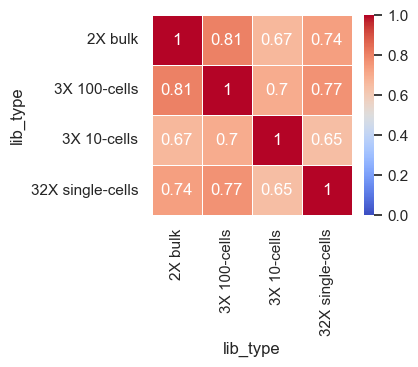

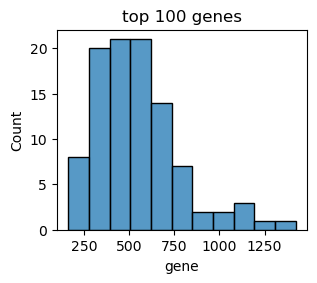

In [39]:
bulk2single_reac_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(bulk2single_reac_1nt, rolling_wins=10)
bulk2single_reac_rolling_10nt = remove_first_and_last_100nts_of_each_gene(bulk2single_reac_rolling_10nt, left_trim=50, right_trim=50)
bulk2single_reac_rolling_10nt = bulk2single_reac_rolling_10nt.dropna(how="any")
bulk_avg_reac = bulk2single_reac_rolling_10nt .groupby(level=['lib_type'], axis=1).mean()
top100_avg_reac = select_top100_reac(expr_df_h9, bulk_avg_reac)
top100_avg_reac.rename(columns={'bulk':'2X bulk','cell_100':'3X 100-cells','cell_10':'3X 10-cells','single':'32X single-cells'}, inplace=True)
t = pd.CategoricalDtype(categories=['2X bulk','3X 100-cells','3X 10-cells','32X single-cells'], ordered=True)
top100_avg_reac.columns = top100_avg_reac.columns.astype(t)
top100_avg_reac = top100_avg_reac.sort_index(axis=1)

sns.set(rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12},style="white", font_scale = 1) ##'figure.figsize':(11.7,8.27),
sns.set_style(style='white')
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(top100_avg_reac.dropna().corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True, ax=ax, annot_kws={'color':'white'}, linewidths=.5, )
plt.subplots_adjust(left=0.4, right=0.9, top=0.9, bottom=0.4)
#plt.savefig("../Current_Figures/02. rRNA_reactivity_correlation/bulk2single.top100_reactivity_correlation.crude_reac.rolling_10nt.pdf")
plt.show()
sns.reset_defaults()

fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.histplot(top100_avg_reac.index.get_level_values('gene').value_counts(), ax=ax)
plt.subplots_adjust(left=0.4, right=0.9, top=0.9, bottom=0.4)
plt.title("top 100 genes")
#plt.savefig("../Current_Figures/02. rRNA_reactivity_correlation/bulk2single.top100_reactivity.deected_len_per_gene.rolling_10nt.pdf")
plt.show()


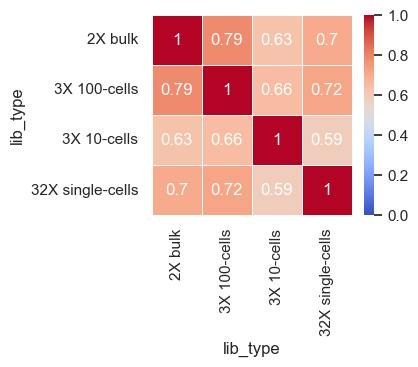

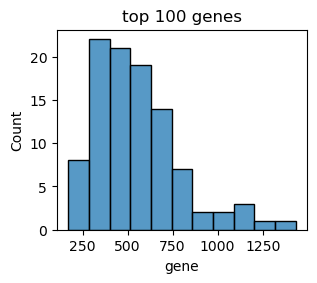

OAZ1        171
ATP5F1B     174
ATP5ME      204
H2AZ1       245
RPS4X       248
           ... 
TPI1       1102
RPL3       1114
GAPDH      1186
ACTB       1232
EEF1A1     1433
Name: gene, Length: 100, dtype: int64

In [40]:
bulk2single_reac_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(bulk2single_reac_1nt, rolling_wins=5)
bulk2single_reac_rolling_10nt = remove_first_and_last_100nts_of_each_gene(bulk2single_reac_rolling_10nt, left_trim=50, right_trim=50)
bulk2single_reac_rolling_10nt = bulk2single_reac_rolling_10nt.dropna(how="any")
bulk_avg_reac = bulk2single_reac_rolling_10nt .groupby(level=['lib_type'], axis=1).mean()
top100_avg_reac = select_top100_reac(expr_df_h9, bulk_avg_reac)
top100_avg_reac.rename(columns={'bulk':'2X bulk','cell_100':'3X 100-cells','cell_10':'3X 10-cells','single':'32X single-cells'}, inplace=True)
t = pd.CategoricalDtype(categories=['2X bulk','3X 100-cells','3X 10-cells','32X single-cells'], ordered=True)
top100_avg_reac.columns = top100_avg_reac.columns.astype(t)
top100_avg_reac = top100_avg_reac.sort_index(axis=1)

sns.set(rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12},style="white", font_scale = 1) ##'figure.figsize':(11.7,8.27),
sns.set_style(style='white')
fig, ax = plt.subplots(1,1, figsize=(5,4))
#sns.heatmap(np.power(top100_avg_reac.dropna().corr(),2), cmap="coolwarm", vmax=1, vmin=0, annot=True, ax=ax, annot_kws={'color':'white'}, linewidths=.5, )
sns.heatmap(top100_avg_reac.dropna().corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True, ax=ax, annot_kws={'color':'white'}, linewidths=.5, )
plt.subplots_adjust(left=0.4, right=0.9, top=0.9, bottom=0.4)
#plt.savefig("../Current_Figures/02. rRNA_reactivity_correlation/bulk2single.top100_reactivity_correlation.crude_reac.rolling_10nt.pdf")
plt.show()
sns.reset_defaults()

fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.histplot(top100_avg_reac.index.get_level_values('gene').value_counts(), ax=ax)
plt.subplots_adjust(left=0.4, right=0.9, top=0.9, bottom=0.4)
plt.title("top 100 genes")
#plt.savefig("../Current_Figures/02. rRNA_reactivity_correlation/bulk2single.top100_reactivity.dected_len_per_gene.rolling_10nt.pdf")
plt.show()

top100_avg_reac.index.get_level_values('gene').value_counts().sort_values()

#### 1.2.2 correlation of gene normalized reactivity

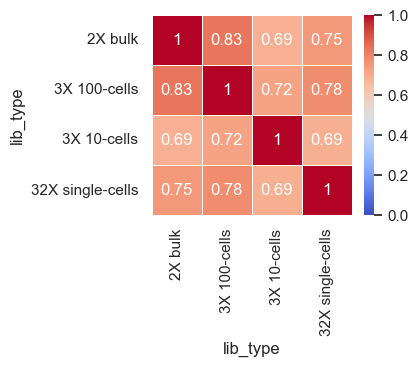

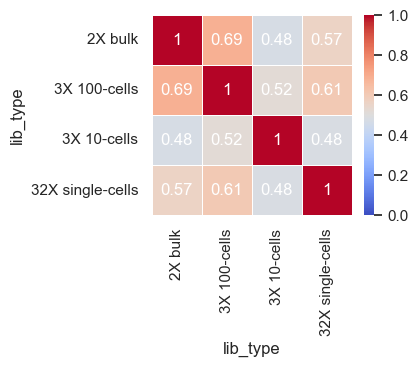

In [74]:
bulk2single_reac_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(bulk2single_reac_1nt.dropna(how="any"), rolling_wins=10)
bulk2single_reac_rolling_10nt = remove_first_and_last_100nts_of_each_gene(bulk2single_reac_rolling_10nt, left_trim=50, right_trim=50)
#bulk2single_reac_rolling_10nt = bulk2single_reac_rolling_10nt.dropna(how="all")

## gene normalization for each cell first then average gnorm_reac
bulk2single_gene_reac_10nt = gene_normalization_1nt(bulk2single_reac_rolling_10nt, bottom_winsorize=0.01, top_winsorize=0.01, gene_winsorize=True)
#bulk2single_gene_reac_10nt = gene_normalization_1nt(bulk2single_reac_rolling_10nt, bottom_winsorize=0.05, top_winsorize=0.01, transcriptome_winsorize=True)
bulk2single_gene_reac_10nt = bulk2single_gene_reac_10nt.dropna(how="any")
bulk_avg_reac = bulk2single_gene_reac_10nt.groupby(level=['lib_type'], axis=1).mean()

## average first then gene normalization
#bulk_avg_reac = bulk2single_reac_rolling_10nt.groupby(level=['lib_type'], axis=1).mean()
#bulk_avg_reac = gene_normalization_1nt(bulk_avg_reac, bottom_winsorize=0.05, top_winsorize=0.01, gene_winsorize=True)

top100_avg_reac = select_top100_reac(expr_df_h9, bulk_avg_reac)

top100_avg_reac.rename(columns={'bulk':'2X bulk','cell_100':'3X 100-cells','cell_10':'3X 10-cells','single':'32X single-cells'}, inplace=True)
t = pd.CategoricalDtype(categories=['2X bulk','3X 100-cells','3X 10-cells','32X single-cells'], ordered=True)
top100_avg_reac.columns = top100_avg_reac.columns.astype(t)
top100_avg_reac = top100_avg_reac.sort_index(axis=1)
#top100_avg_reac.to_csv("../Current_Figures/02. rRNA_reactivity_correlation/Results/bulk2single.top100_avg_reactivity.gnorm_reac.rolling_10nt.csv")

sns.set(rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12},style="white", font_scale = 1) ##'figure.figsize':(11.7,8.27),
sns.set_style(style='white')
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(top100_avg_reac.dropna().corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True, ax=ax, annot_kws={'color':'white'}, linewidths=.5, )
plt.subplots_adjust(left=0.4, right=0.9, top=0.9, bottom=0.4)
#plt.savefig("../Current_Figures/02. rRNA_reactivity_correlation/bulk2single.top100_avg_reactivity_correlation.gnorm_reac.rolling_10nt.pdf")
plt.show()
sns.reset_defaults()

#top100_avg_reac.dropna().corr().to_csv("../Current_Figures/02. rRNA_reactivity_correlation/Results/bulk2single.top100_avg_reactivity_correlation.gnorm_reac.rolling_10nt.csv")


sns.set(rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12},style="white", font_scale = 1) ##'figure.figsize':(11.7,8.27),
sns.set_style(style='white')
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(np.power(top100_avg_reac.dropna().corr(),2), cmap="coolwarm", vmax=1, vmin=0, annot=True, ax=ax, annot_kws={'color':'white'}, linewidths=.5, )
plt.subplots_adjust(left=0.4, right=0.9, top=0.9, bottom=0.4)
plt.savefig("../Current_Figures/02. rRNA_reactivity_correlation/bulk2single.top100_avg_reactivity_correlation.gnorm_reac.rolling_10nt.Rsquare.pdf")
plt.show()
sns.reset_defaults()


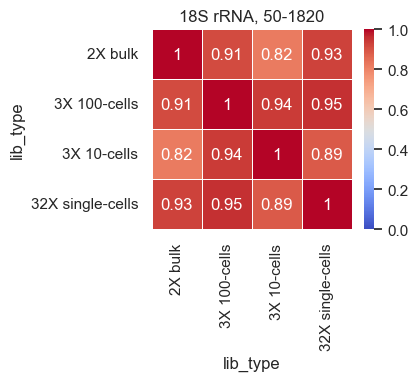

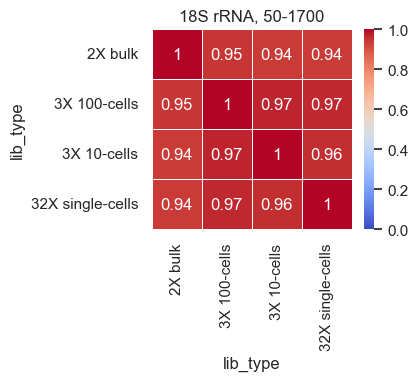

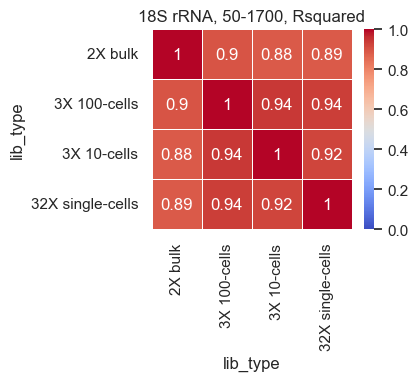

In [33]:
rRNA_avg_reac = bulk2single_gene_reac_10nt.loc[bulk2single_gene_reac_10nt.index.get_level_values('gene')=="human_small"].groupby(level=['lib_type'], axis=1).mean()
#rRNA_avg_reac = bulk2single_reac_1nt.loc[bulk2single_reac_1nt.index.get_level_values('gene')=="human_small"].groupby(level=['lib_type'], axis=1).mean()

#rRNA_avg_reac = rRNA_avg_reac.loc[rRNA_avg_reac.index.get_level_values('pos')<=1720]
rRNA_avg_reac.rename(columns={'bulk':'2X bulk','cell_100':'3X 100-cells','cell_10':'3X 10-cells','single':'32X single-cells'}, inplace=True)
t = pd.CategoricalDtype(categories=['2X bulk','3X 100-cells','3X 10-cells','32X single-cells'], ordered=True)
rRNA_avg_reac.columns = rRNA_avg_reac.columns.astype(t)
rRNA_avg_reac = rRNA_avg_reac.sort_index(axis=1)
#rRNA_avg_reac.to_csv("../Current_Figures/02. rRNA_reactivity_correlation/Results/bulk2single.rRNA_avg_reactivity.gnorm_reac.rolling_10nt.csv")

sns.set(rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12},style="white", font_scale = 1) ##'figure.figsize':(11.7,8.27),
sns.set_style(style='white')
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(rRNA_avg_reac.dropna().corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True, ax=ax, annot_kws={'color':'white'}, linewidths=.5, )
plt.subplots_adjust(left=0.4, right=0.9, top=0.9, bottom=0.4)
plt.title("18S rRNA, 50-1820")
#plt.savefig("../Current_Figures/02. rRNA_reactivity_correlation/bulk2single.rRNA_reactivity_correlation.gnorm_reac.rolling_10nt.full_len.pdf")
plt.show()
sns.reset_defaults()


rRNA_avg_reac = bulk2single_gene_reac_10nt.loc[bulk2single_gene_reac_10nt.index.get_level_values('gene')=="human_small"].groupby(level=['lib_type'], axis=1).mean()
#rRNA_avg_reac = bulk2single_reac_1nt.loc[bulk2single_reac_1nt.index.get_level_values('gene')=="human_small"].groupby(level=['lib_type'], axis=1).mean()

rRNA_avg_reac = rRNA_avg_reac.loc[rRNA_avg_reac.index.get_level_values('pos')>=50]
rRNA_avg_reac = rRNA_avg_reac.loc[rRNA_avg_reac.index.get_level_values('pos')<=1700]

rRNA_avg_reac.rename(columns={'bulk':'2X bulk','cell_100':'3X 100-cells','cell_10':'3X 10-cells','single':'32X single-cells'}, inplace=True)
t = pd.CategoricalDtype(categories=['2X bulk','3X 100-cells','3X 10-cells','32X single-cells'], ordered=True)
rRNA_avg_reac.columns = rRNA_avg_reac.columns.astype(t)
rRNA_avg_reac = rRNA_avg_reac.sort_index(axis=1)

sns.set(rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12},style="white", font_scale = 1) ##'figure.figsize':(11.7,8.27),
sns.set_style(style='white')
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(rRNA_avg_reac.dropna().corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True, ax=ax, annot_kws={'color':'white'}, linewidths=.5, )
plt.subplots_adjust(left=0.4, right=0.9, top=0.9, bottom=0.4)
plt.title("18S rRNA, 50-1700")
#plt.savefig("../Current_Figures/02. rRNA_reactivity_correlation/bulk2single.rRNA_reactivity_correlation.gnorm_reac.rolling_10nt.50-1700.pdf")
plt.show()
sns.reset_defaults()

sns.set(rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12},style="white", font_scale = 1) ##'figure.figsize':(11.7,8.27),
sns.set_style(style='white')
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(np.power(rRNA_avg_reac.dropna().corr(),2), cmap="coolwarm", vmax=1, vmin=0, annot=True, ax=ax, annot_kws={'color':'white'}, linewidths=.5, )
plt.subplots_adjust(left=0.4, right=0.9, top=0.9, bottom=0.4)
plt.title("18S rRNA, 50-1700, Rsquared")
plt.savefig("../Current_Figures/02. rRNA_reactivity_correlation/bulk2single.rRNA_reactivity_correlation.gnorm_reac.rolling_10nt.50-1700.Rsquared.pdf")
plt.show()
sns.reset_defaults()

#### 1.2.3 correlation of transcrtiptome scaled reactivity

#### 1.2.4 Correlation Distribution

In [10]:
bulk2single_reac_1nt 

bulk2single_reac_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(bulk2single_reac_1nt, rolling_wins=5)
#bulk2single_reac_rolling_10nt = bulk2single_reac_1nt.copy()

bulk2single_reac_rolling_10nt = remove_first_and_last_100nts_of_each_gene(bulk2single_reac_rolling_10nt, left_trim=50, right_trim=50)
bulk2single_reac_rolling_10nt = bulk2single_reac_rolling_10nt.dropna(how="any")
#bulk_avg_reac = bulk2single_reac_rolling_10nt .groupby(level=['lib_type'], axis=1).mean()
top100_reac = select_top100_reac(expr_df_h9,bulk2single_reac_rolling_10nt)

In [14]:
bulk_reac= top100_reac.xs("bulk", level="lib_type", axis=1, drop_level=False)
cell_10_reac= top100_reac.xs("cell_10", level="lib_type", axis=1, drop_level=False)
cell_100_reac= top100_reac.xs("cell_100", level="lib_type", axis=1, drop_level=False)
single_reac= top100_reac.xs("single", level="lib_type", axis=1, drop_level=False)

#rRNA_reac = bulk2single_reac_rolling_10nt.xs('human_small', level="gene", drop_level=False)
#bulk_reac= rRNA_reac.xs("bulk", level="lib_type", axis=1, drop_level=False)
#cell_10_reac= rRNA_reac.xs("cell_10", level="lib_type", axis=1, drop_level=False)
#cell_100_reac= rRNA_reac.xs("cell_100", level="lib_type", axis=1, drop_level=False)
#single_reac= rRNA_reac.xs("single", level="lib_type", axis=1, drop_level=False)

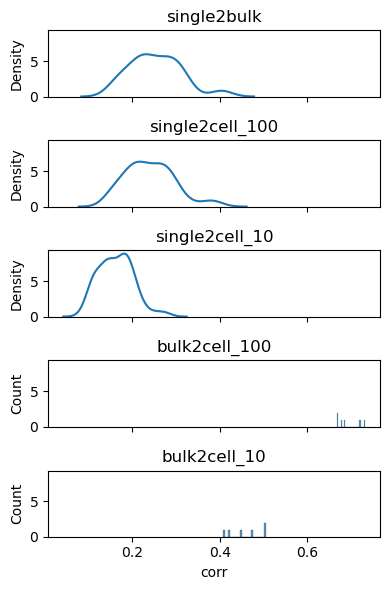

                                                                       corr
id      batch   stage lib_type id.2    batch.2 stage.2 lib_type.2          
RHE1536 batch_1 h9    cell_100 RHE1566 batch_1 h9      bulk        0.669923
                               RHE1572 batch_1 h9      bulk        0.679314
RHE1542 batch_1 h9    cell_100 RHE1566 batch_1 h9      bulk        0.667146
                               RHE1572 batch_1 h9      bulk        0.684838
RHE1548 batch_1 h9    cell_100 RHE1566 batch_1 h9      bulk        0.718886
                               RHE1572 batch_1 h9      bulk        0.731435
                                                                       corr
id      batch   stage lib_type id.2    batch.2 stage.2 lib_type.2          
RHE1547 batch_1 h9    cell_10  RHE1566 batch_1 h9      bulk        0.501507
                               RHE1572 batch_1 h9      bulk        0.504961
RHE1553 batch_1 h9    cell_10  RHE1566 batch_1 h9      bulk        0.407810
            

In [15]:
def pw_corr(single_reac, bulk_reac):
    concat_lst = []
    for col_id, col in bulk_reac.items():
        out = single_reac.corrwith(col)
        out = out.to_frame(col_id)
        concat_lst.append(out)
    out = pd.concat(concat_lst, axis=1)
    out.columns.names = ['id.2','batch.2','stage.2','lib_type.2']
    out = out.stack([0,1,2,3]).to_frame('corr')
    return out
        
single2bulk_corr = pw_corr(single_reac, bulk_reac)
single2c10_corr = pw_corr(single_reac, cell_10_reac)
single2c100_corr = pw_corr(single_reac, cell_100_reac)
c102bulk_corr = pw_corr(cell_10_reac, bulk_reac)
c1002bulk_corr = pw_corr(cell_100_reac, bulk_reac)

fig, ax = plt.subplots(5,1, sharex=True, sharey=True, figsize=(4,6))
sns.kdeplot(data=single2bulk_corr, x="corr", label="single2bulk", ax=ax[0])
#sns.histplot(data=single2bulk_corr, x="corr", label="single2bulk", ax=ax[0], bins=20)

sns.kdeplot(data=single2c10_corr, x="corr", label="single2cell_10", ax=ax[2])
#sns.histplot(data=single2c10_corr, x="corr", label="single2cell_10", ax=ax[2], bins=20)

sns.kdeplot(data=single2c100_corr, x="corr", label="single2cell_100", ax=ax[1])
#sns.histplot(data=single2c100_corr, x="corr", label="single2cell_100", ax=ax[1], bins=20)

sns.histplot(data=c1002bulk_corr, x="corr", label="c1002bulk_corr", ax=ax[3], bins=20)
sns.histplot(data=c102bulk_corr, x="corr", label="c102bulk_corr", ax=ax[4], bins=20)



ax[0].set_title("single2bulk")
ax[1].set_title("single2cell_100")
ax[2].set_title("single2cell_10")
ax[3].set_title("bulk2cell_100")
ax[4].set_title("bulk2cell_10")


plt.tight_layout()
plt.savefig("../Current_Figures/07.Single_cell_correlation_distribution/singlecell_to_bulk_corr_distribution.kdeplot.top100genes.pdf")
plt.show()

print (c1002bulk_corr)
print (c102bulk_corr)

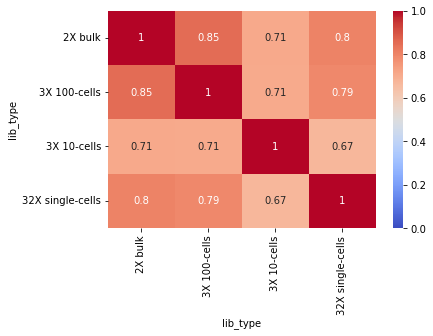

In [276]:
bulk2single_reac_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(bulk2single_reac_1nt, rolling_wins=10)
bulk2single_reac_rolling_10nt = remove_first_and_last_100nts_of_each_gene(bulk2single_reac_rolling_10nt, left_trim=50, right_trim=50)
bulk2single_reac_rolling_10nt = bulk2single_reac_rolling_10nt.dropna(how="any")

crude_reac_array = bulk2single_reac_rolling_10nt.to_numpy()
crude_reac_array = winsorize(crude_reac_array, limits=[0.05, 0.01], axis=0, nan_policy="omit")
bulk2single_reac_rolling_10nt = pd.DataFrame(crude_reac_array, index=bulk2single_reac_rolling_10nt.index, columns=bulk2single_reac_rolling_10nt.columns)

from sklearn.preprocessing import MinMaxScaler
scalor = MinMaxScaler().fit(bulk2single_reac_rolling_10nt)
scaled_bulk2single_reac_10nt = scalor.transform(bulk2single_reac_rolling_10nt)
scaled_bulk2single_reac_10nt = pd.DataFrame(scaled_bulk2single_reac_10nt, index=bulk2single_reac_rolling_10nt.index, columns=bulk2single_reac_rolling_10nt.columns)
scaled_bulk2single_reac_10nt

bulk_avg_reac = scaled_bulk2single_reac_10nt.groupby(level=['lib_type'], axis=1).mean()
top100_avg_reac = select_top100_reac(expr_df_h9, bulk_avg_reac)

top100_avg_reac.rename(columns={'bulk':'2X bulk','cell_100':'3X 100-cells','cell_10':'3X 10-cells','single':'32X single-cells'}, inplace=True)
t = pd.CategoricalDtype(categories=['2X bulk','3X 100-cells','3X 10-cells','32X single-cells'], ordered=True)
top100_avg_reac.columns = top100_avg_reac.columns.astype(t)
top100_avg_reac = top100_avg_reac.sort_index(axis=1)
sns.heatmap(top100_avg_reac.dropna().corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True)
plt.show()

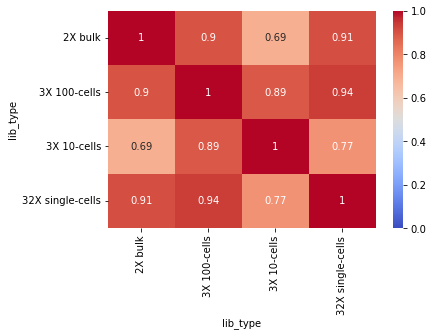

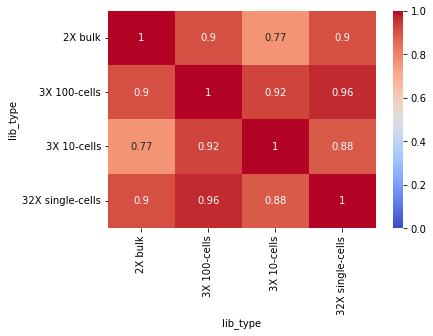

In [277]:
rRNA_avg_reac = scaled_bulk2single_reac_10nt.loc[scaled_bulk2single_reac_10nt.index.get_level_values('gene')=="human_small"].groupby(level=['lib_type'], axis=1).mean()
rRNA_avg_reac.rename(columns={'bulk':'2X bulk','cell_100':'3X 100-cells','cell_10':'3X 10-cells','single':'32X single-cells'}, inplace=True)
t = pd.CategoricalDtype(categories=['2X bulk','3X 100-cells','3X 10-cells','32X single-cells'], ordered=True)
rRNA_avg_reac.columns = rRNA_avg_reac.columns.astype(t)
rRNA_avg_reac = rRNA_avg_reac.sort_index(axis=1)
sns.heatmap(rRNA_avg_reac.dropna().corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True)
plt.show()


rRNA_avg_reac = scaled_bulk2single_reac_10nt.loc[scaled_bulk2single_reac_10nt.index.get_level_values('gene')=="human_small"].groupby(level=['lib_type'], axis=1).mean()
rRNA_avg_reac = rRNA_avg_reac.loc[rRNA_avg_reac.index.get_level_values('pos')<=1770]
rRNA_avg_reac.rename(columns={'bulk':'2X bulk','cell_100':'3X 100-cells','cell_10':'3X 10-cells','single':'32X single-cells'}, inplace=True)
t = pd.CategoricalDtype(categories=['2X bulk','3X 100-cells','3X 10-cells','32X single-cells'], ordered=True)
rRNA_avg_reac.columns = rRNA_avg_reac.columns.astype(t)
rRNA_avg_reac = rRNA_avg_reac.sort_index(axis=1)
sns.heatmap(rRNA_avg_reac.dropna().corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True)
plt.show()

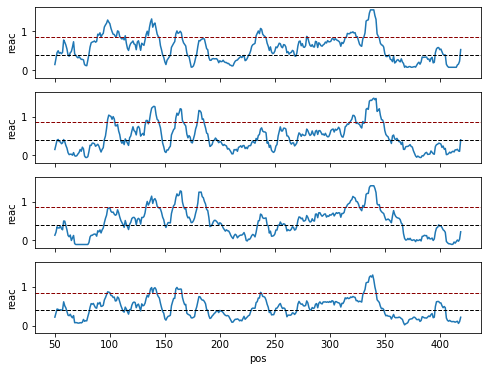

In [238]:
#GENE = "RPS27"
#GENE = "human_small"
#GENE = "RPL18A"
GENE = "RPL41"
#GENE = "RPL13"
#GENE = "ACTB"
#GENE = "MT-ND4"
#GENE = "FTL"
#GENE = "TPI1" ## badly correlated
#GENE = "TMSB4X" ## badly correlated

gene_reac_1nt = bulk2single_gene_reac_10nt.loc[GENE]
gene_avg_reac_1nt = gene_reac_1nt.groupby(level="lib_type", axis=1).mean()
stacked_gene_avg_reac_1nt = gene_avg_reac_1nt.stack().to_frame('reac').reset_index()
stacked_gene_avg_reac_1nt
n = 0 
fig, axs = plt.subplots(4,1, sharex=True, sharey=True, figsize=(8,6))
for lib_type, subset in stacked_gene_avg_reac_1nt.groupby('lib_type'):
    sns.lineplot(data=subset, x="pos", y="reac", ax=axs[n])
    axs[n].axhline(y=0.85, ls="--", lw=1, color="darkred")
    axs[n].axhline(y=0.4, ls="--", lw=1, color="black")
    n += 1
plt.show()

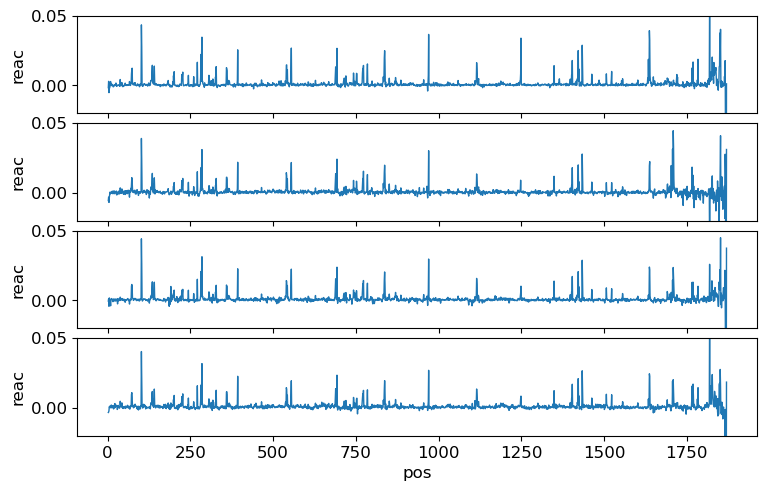

In [120]:
GENE = "human_small"

gene_reac_1nt = bulk2single_reac_1nt.loc[GENE]
gene_avg_reac_1nt = gene_reac_1nt.groupby(level="lib_type", axis=1).mean()
stacked_gene_avg_reac_1nt = gene_avg_reac_1nt.stack().to_frame('reac').reset_index()
stacked_gene_avg_reac_1nt
n = 0 
params = {'legend.fontsize': 'medium',
          'figure.figsize': (16, 4),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'lines.linewidth' : 1,
          'lines.markersize' : 10,
          'figure.subplot.left': 0.05,
          'figure.subplot.right': 0.9,
          'figure.subplot.top': 0.9,
          'figure.subplot.bottom': 0.2,
          'figure.subplot.wspace': 0.1,
          'figure.subplot.hspace': 0.1,}
pylab.rcParams.update(params)
fig, axs = plt.subplots(4,1, sharex=True, sharey=True, figsize=(8,6))
for lib_type, subset in stacked_gene_avg_reac_1nt.groupby('lib_type'):
    sns.lineplot(data=subset, x="pos", y="reac", ax=axs[n])
    #axs[n].axhline(y=0.85, ls="--", lw=1, color="darkred")
    #axs[n].axhline(y=0.4, ls="--", lw=1, color="black")
    axs[n].set_ylim(-0.02,0.05)
    n += 1
plt.show()



In [ ]:
gene_reac_1nt = scaled_bulk2single_reac_10nt.loc[GENE]
gene_avg_reac_1nt = gene_reac_1nt.groupby(level="lib_type", axis=1).mean()
stacked_gene_avg_reac_1nt = gene_avg_reac_1nt.stack().to_frame('reac').reset_index()
stacked_gene_avg_reac_1nt
n = 0 
fig, axs = plt.subplots(4,1, sharex=True, sharey=True, figsize=(8,6))
for lib_type, subset in stacked_gene_avg_reac_1nt.groupby('lib_type'):
    sns.lineplot(data=subset, x="pos", y="reac", ax=axs[n])
    n += 1
plt.show()

### 1.3 AUC-ROC Accuracy

In [80]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

#### 1.3.1 18S rRNA dotbracket pairing 

In [78]:
with open("../../../../FigureFactory/rRNA_ROC/human_18S.dot") as f:
    for l in f:
        if l[0] == ">":
            name = l[1:].strip("\n")
        elif l[0] in ['A','T','C','G','U']:
            seq = list(l.strip("\n"))
        elif l[0] in ['.','(',')',"<",">"]:
            dotbrackets = list(l.strip("\n"))
hg_rRNA_dotbrackets_df = pd.DataFrame([seq, dotbrackets]).T
hg_rRNA_dotbrackets_df.columns = ['seq','dotbracket']
print (hg_rRNA_dotbrackets_df.iloc[18:21])
hg_rRNA_dotbrackets_df['Nucleotide'] = list(range(1, hg_rRNA_dotbrackets_df.index.size+1))
hg_rRNA_dotbrackets_df['unpair'] = 0
hg_rRNA_dotbrackets_df.loc[hg_rRNA_dotbrackets_df['dotbracket']==".", 'unpair'] = 1
hg_rRNA_dotbrackets_df = hg_rRNA_dotbrackets_df.set_index('Nucleotide')
# hg_rRNA_dotbrackets_df.index = list(range(hg_rRNA_dotbrackets_df.index.size))
hg_rRNA_dotbrackets_df

   seq dotbracket
18   A          )
19   G          )
20   U          .


,seq,dotbracket,unpair
Nucleotide,,,
1,U,.,1
2,A,.,1
3,C,.,1
4,C,(,0
5,U,(,0
...,...,...,...
1866,C,.,1
1867,A,.,1
1868,U,.,1


#### 1.3.2 18S rRNA reac

In [76]:
bulk2single_mutrate_1nt_rRNA = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/batch_1.h9.bulk2single.mutrate.1nt.rRNA.csv", header=[0,1,2,3,4], index_col=[0,1])
bulk2single_reac_1nt_rRNA = iterate_batch_stages_for_reactivity_from_mutrate_matrix(bulk2single_mutrate_1nt_rRNA)

bulk2single_reac_rolling_10nt_rRNA = smooth_by_avg_reac_of_rolling_wins(bulk2single_reac_1nt_rRNA, rolling_wins=5)
bulk2single_reac_rolling_10nt_rRNA = bulk2single_reac_1nt_rRNA
bulk2single_reac_rolling_10nt_rRNA.dropna(how="all")

bulk2single_gene_reac_10nt_rRNA = gene_normalization_1nt(bulk2single_reac_rolling_10nt_rRNA, bottom_winsorize=0.05, top_winsorize=0.01, gene_winsorize=True)
bulk2single_gene_reac_10nt_rRNA = bulk2single_gene_reac_10nt_rRNA.dropna(how="any")

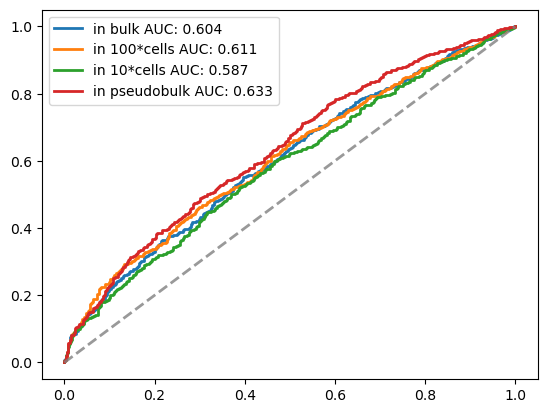

In [82]:
bulk2single_reac_rolling_10nt_rRNA_avgreac = bulk2single_reac_rolling_10nt_rRNA.xs("batch_1", level="batch", axis=1, drop_level=False).dropna(how="all").groupby(level="lib_type", axis=1).mean()
bulk2single_reac_rolling_10nt_rRNA_avgreac = bulk2single_reac_rolling_10nt_rRNA_avgreac.loc['human_small']
bulk2single_reac_rolling_10nt_rRNA_avgreac

bulk2single_reac_rolling_10nt_rRNA_avgreac = pd.concat([bulk2single_reac_rolling_10nt_rRNA_avgreac, hg_rRNA_dotbrackets_df], axis=1, join="inner")
bulk2single_reac_rolling_10nt_rRNA_avgreac = bulk2single_reac_rolling_10nt_rRNA_avgreac.loc[range(50,1700)]



roc_bulk =  roc_auc_score(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['bulk'].to_list())
roc_100cells =  roc_auc_score(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['cell_100'].to_list())
roc_10cells =  roc_auc_score(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['cell_10'].to_list())
roc_single =  roc_auc_score(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['single'].to_list())

bulk_fpr, bulk_tpr, _ = roc_curve(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['bulk'].to_list())
cell100_fpr, cell100_tpr, _ = roc_curve(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['cell_100'].to_list())
cell10_fpr, cell10_tpr, _ = roc_curve(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['cell_10'].to_list())
single_fpr, single_tpr, _ = roc_curve(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['single'].to_list())

fig, ax = plt.subplots()

ax.plot(bulk_fpr, bulk_tpr, marker='.', label='in bulk AUC: {}'.format(np.round(roc_bulk,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot(cell100_fpr, cell100_tpr, marker='.', label='in 100*cells AUC: {}'.format(np.round(roc_100cells,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot(cell10_fpr, cell10_tpr, marker='.', label='in 10*cells AUC: {}'.format(np.round(roc_10cells,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot(single_fpr, single_tpr, marker='.', label='in pseudobulk AUC: {}'.format(np.round(roc_single,3)), linewidth=2, markersize=0, ) #color="blue" 


ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)
plt.legend()
#plt.savefig("ROC.reac.pdf")
plt.show()

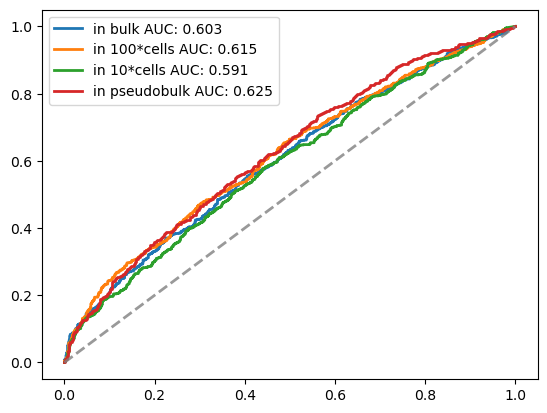

In [83]:
bulk2single_gene_reac_10nt_rRNA_avgreac = bulk2single_gene_reac_10nt_rRNA.xs("batch_1", level="batch", axis=1, drop_level=False).dropna(how="all").groupby(level="lib_type", axis=1).mean()
bulk2single_gene_reac_10nt_rRNA_avgreac = bulk2single_gene_reac_10nt_rRNA_avgreac.loc['human_small']
bulk2single_gene_reac_10nt_rRNA_avgreac

bulk2single_gene_reac_10nt_rRNA_avgreac = pd.concat([bulk2single_gene_reac_10nt_rRNA_avgreac, hg_rRNA_dotbrackets_df], axis=1, join="inner")
bulk2single_gene_reac_10nt_rRNA_avgreac = bulk2single_gene_reac_10nt_rRNA_avgreac.loc[range(50,1800)]


roc_bulk =  roc_auc_score(bulk2single_gene_reac_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_gene_reac_10nt_rRNA_avgreac['bulk'].to_list())
roc_100cells =  roc_auc_score(bulk2single_gene_reac_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_gene_reac_10nt_rRNA_avgreac['cell_100'].to_list())
roc_10cells =  roc_auc_score(bulk2single_gene_reac_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_gene_reac_10nt_rRNA_avgreac['cell_10'].to_list())
roc_single =  roc_auc_score(bulk2single_gene_reac_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_gene_reac_10nt_rRNA_avgreac['single'].to_list())

bulk_fpr, bulk_tpr, _ = roc_curve(bulk2single_gene_reac_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_gene_reac_10nt_rRNA_avgreac['bulk'].to_list())
cell100_fpr, cell100_tpr, _ = roc_curve(bulk2single_gene_reac_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_gene_reac_10nt_rRNA_avgreac['cell_100'].to_list())
cell10_fpr, cell10_tpr, _ = roc_curve(bulk2single_gene_reac_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_gene_reac_10nt_rRNA_avgreac['cell_10'].to_list())
single_fpr, single_tpr, _ = roc_curve(bulk2single_gene_reac_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_gene_reac_10nt_rRNA_avgreac['single'].to_list())

fig, ax = plt.subplots()

ax.plot(bulk_fpr, bulk_tpr, marker='.', label='in bulk AUC: {}'.format(np.round(roc_bulk,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot(cell100_fpr, cell100_tpr, marker='.', label='in 100*cells AUC: {}'.format(np.round(roc_100cells,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot(cell10_fpr, cell10_tpr, marker='.', label='in 10*cells AUC: {}'.format(np.round(roc_10cells,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot(single_fpr, single_tpr, marker='.', label='in pseudobulk AUC: {}'.format(np.round(roc_single,3)), linewidth=2, markersize=0, ) #color="blue" 


ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)
plt.legend()
#plt.savefig("ROC.reac.pdf")
plt.show()

single 0.5555304364938058
single 0.5792140675075435
single 0.5460307457315816
single 0.5276515967914238
single 0.5693231441048036
single 0.5589689497160635
single 0.5495008855445396
single 0.5583018629233277
single 0.5664117407275522
single 0.5640538026875574
single 0.5246406282212268
single 0.5473075229117079
single 0.5732015012088386
single 0.5618042150045917
single 0.54776786550968
single 0.6108582285360871
single 0.6032069362970182
single 0.5849718640478287
single 0.59178739434376
single 0.6039249770414379
single 0.6038107699083531
single 0.6086408531214273
single 0.5557213673932192
single 0.6014832871038476
single 0.6038464962422925
single 0.6123259366156268
single 0.5753286822722417
single 0.581785192195963
single 0.5881907481680004
single 0.6054893219258954
single 0.5854527053619957
single 0.5711937983769703
single 0.5967457409524524
single 0.5683802031598478
single 0.5860442397436137
single 0.6306459321176228
single 0.6015781668759488
single 0.5811971718799782
single 0.59266766

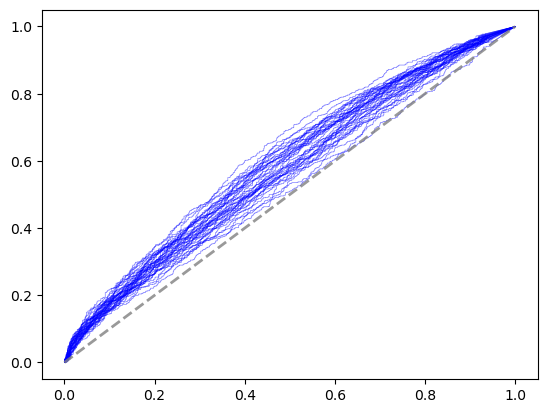

In [84]:
fig, ax = plt.subplots()

for (id, batch,stage,lib_type), col_df in bulk2single_gene_reac_10nt_rRNA.dropna(how="any").items():
    if batch == "batch_2":
        continue
    if lib_type != "single":
        continue
    col_df = col_df.to_frame()
    col_df.columns = [lib_type]
    col_df = col_df.loc['human_small']
    col_df = col_df.dropna()
    col_df = pd.concat([col_df, hg_rRNA_dotbrackets_df], axis=1, join="inner")
    
    roc_value =  roc_auc_score(col_df['unpair'].astype("bool").to_list(), col_df[lib_type].to_list())
    sample_fpr, sample_tpr, _ = roc_curve(col_df['unpair'].astype("bool").to_list(), col_df[lib_type].to_list())
    ax.plot(sample_fpr, sample_tpr, marker='.',  linewidth=0.5, markersize=0, color="blue", alpha=0.5 ) #color="blue" 
    print (lib_type, roc_value)
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)
plt.show()

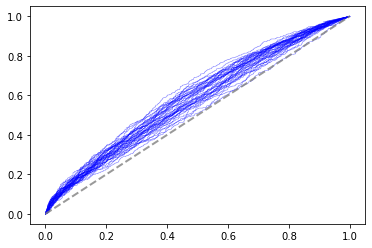

<AxesSubplot:xlabel='1', ylabel='Count'>

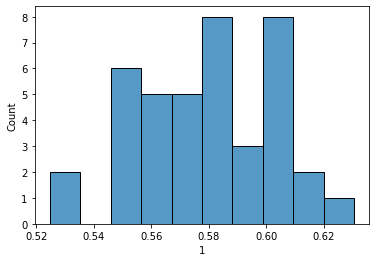

In [167]:
fig, ax = plt.subplots()
auc_lst = []
for (id, batch,stage,lib_type), col_df in bulk2single_gene_reac_10nt_rRNA.items():
    if batch == "batch_2":
        continue
    if lib_type != "single":
        continue
    col_df = col_df.to_frame()
    col_df.columns = [lib_type]
    col_df = col_df.loc['human_small']
    col_df = col_df.dropna()
    col_df = pd.concat([col_df, hg_rRNA_dotbrackets_df], axis=1, join="inner")
    
    roc_value =  roc_auc_score(col_df['unpair'].astype("bool").to_list(), col_df[lib_type].to_list())
    sample_fpr, sample_tpr, _ = roc_curve(col_df['unpair'].astype("bool").to_list(), col_df[lib_type].to_list())
    ax.plot(sample_fpr, sample_tpr, marker='.',  linewidth=0.5, markersize=0, color="blue", alpha=0.5 ) #color="blue" 
    #print (lib_type, roc_value)
    auc_lst.append([lib_type, roc_value])
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)
plt.show()

auc_df = pd.DataFrame(auc_lst)
sns.histplot(data=auc_df, x=1, bins=10)

#### 1.3.3 18S rRNA mutrate (DMSO)

bulk 0.44817445357287644
cell_10 0.4440941437304316
cell_100 0.4457191674931117
single 0.4514073232571935


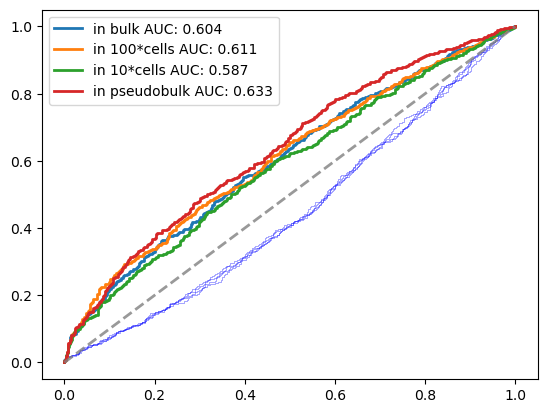

In [113]:
local_mutrate_rRNA_1nt = bulk2single_mutrate_1nt_rRNA.groupby(level=['agent','lib_type'], axis=1).mean()
#local_mutrate_rRNA_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(local_mutrate_rRNA_1nt, rolling_wins=10)


fig, ax = plt.subplots()
for libtype, local_subset in local_mutrate_rRNA_1nt.groupby(level='lib_type', axis=1):
#for libtype, local_subset in local_mutrate_rRNA_rolling_10nt.groupby(level='lib_type', axis=1):
    local_subset = local_subset.dropna()
    local_subset = local_subset.droplevel('lib_type', axis=1)
    local_subset['reac'] = local_subset['nai-n3'] - local_subset['dmso']
    local_subset = pd.concat([local_subset.xs("human_small", level="gene"), hg_rRNA_dotbrackets_df], axis=1, join="inner")
    ## DMSO
    roc_value_dmso =  roc_auc_score(local_subset['unpair'].astype("bool").to_list(), local_subset['dmso'].to_list())
    sample_fpr, sample_tpr, _ = roc_curve(local_subset['unpair'].astype("bool").to_list(), local_subset['dmso'].to_list())
    ax.plot(sample_fpr, sample_tpr, marker='.',  linewidth=0.5, markersize=0, color="blue", alpha=0.5 ) #color="blue" 
    ## NAI-N3
    #roc_value_nain3 =  roc_auc_score(local_subset['unpair'].astype("bool").to_list(), local_subset['nai-n3'].to_list())
    #sample_fpr, sample_tpr, _ = roc_curve(local_subset['unpair'].astype("bool").to_list(), local_subset['nai-n3'].to_list())
    #ax.plot(sample_fpr, sample_tpr, marker='.',  linewidth=0.5, markersize=0, color="orange", alpha=0.5 ) #color="blue" 
    
    print (libtype, roc_value_dmso)

bulk2single_reac_rolling_10nt_rRNA_avgreac = bulk2single_reac_rolling_10nt_rRNA.xs("batch_1", level="batch", axis=1, drop_level=False).dropna(how="all").groupby(level="lib_type", axis=1).mean()
bulk2single_reac_rolling_10nt_rRNA_avgreac = bulk2single_reac_rolling_10nt_rRNA_avgreac.loc['human_small']
bulk2single_reac_rolling_10nt_rRNA_avgreac
bulk2single_reac_rolling_10nt_rRNA_avgreac = pd.concat([bulk2single_reac_rolling_10nt_rRNA_avgreac, hg_rRNA_dotbrackets_df], axis=1, join="inner")
bulk2single_reac_rolling_10nt_rRNA_avgreac = bulk2single_reac_rolling_10nt_rRNA_avgreac.loc[range(50,1700)]


roc_bulk =  roc_auc_score(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['bulk'].to_list())
roc_100cells =  roc_auc_score(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['cell_100'].to_list())
roc_10cells =  roc_auc_score(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['cell_10'].to_list())
roc_single =  roc_auc_score(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['single'].to_list())

bulk_fpr, bulk_tpr, _ = roc_curve(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['bulk'].to_list())
cell100_fpr, cell100_tpr, _ = roc_curve(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['cell_100'].to_list())
cell10_fpr, cell10_tpr, _ = roc_curve(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['cell_10'].to_list())
single_fpr, single_tpr, _ = roc_curve(bulk2single_reac_rolling_10nt_rRNA_avgreac['unpair'].astype("bool").to_list(), bulk2single_reac_rolling_10nt_rRNA_avgreac['single'].to_list())

ax.plot(bulk_fpr, bulk_tpr, marker='.', label='in bulk AUC: {}'.format(np.round(roc_bulk,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot(cell100_fpr, cell100_tpr, marker='.', label='in 100*cells AUC: {}'.format(np.round(roc_100cells,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot(cell10_fpr, cell10_tpr, marker='.', label='in 10*cells AUC: {}'.format(np.round(roc_10cells,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot(single_fpr, single_tpr, marker='.', label='in pseudobulk AUC: {}'.format(np.round(roc_single,3)), linewidth=2, markersize=0, ) #color="blue" 


plt.legend() 
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)
plt.show()

In [96]:
local_subset

,,dmso,nai-n3,seq,dotbracket,unpair


In [95]:
hg_rRNA_dotbrackets_df

,seq,dotbracket,unpair
Nucleotide,,,
1,U,.,1
2,A,.,1
3,C,.,1
4,C,(,0
5,U,(,0
...,...,...,...
1866,C,.,1
1867,A,.,1
1868,U,.,1


### 1.4 reactivity distribution at unpaired, boundary, paired nucleotides

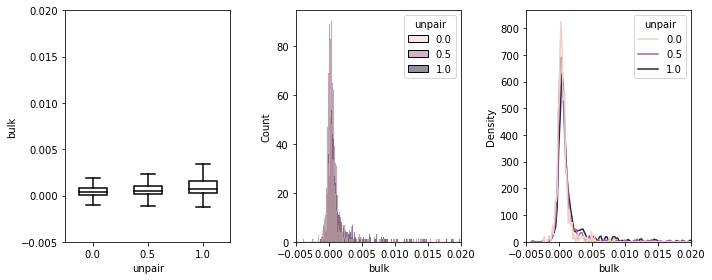

In [158]:
previous = None
boundary_concat_lst = []
out_concat_lst = []
for pos, row in bulk2single_reac_rolling_10nt_rRNA_avgreac.sort_index().iterrows():
    if previous == row['unpair']:
        pass
    elif previous != row['unpair']:
        #print (gene, pos)
        try:
            #print (pos)
            out_df = bulk2single_reac_rolling_10nt_rRNA_avgreac.loc[[pos-1, pos]]
            out_concat_lst.append(out_df)
        except:
            pass
        previous = row['unpair']
out_df = pd.concat(out_concat_lst)
out_df = out_df.drop_duplicates().sort_index()
out_df['unpair'] = 0.5

bulk2single_reac_rolling_10nt_rRNA_avgreac_changeboundary = bulk2single_reac_rolling_10nt_rRNA_avgreac.loc[~bulk2single_reac_rolling_10nt_rRNA_avgreac.index.isin(out_df.index)]
bulk2single_reac_rolling_10nt_rRNA_avgreac_changeboundary = pd.concat([bulk2single_reac_rolling_10nt_rRNA_avgreac_changeboundary, out_df]).sort_index()
bulk2single_reac_rolling_10nt_rRNA_avgreac_changeboundary

fig, axs = plt.subplots(1,3, figsize=(10,4))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

ax = axs[0]
sns.boxplot(data=bulk2single_reac_rolling_10nt_rRNA_avgreac_changeboundary, x="unpair", y="bulk", showfliers=True, color='white', width=.5, fliersize=0, ax=ax, **PROPS)
#plt.setp(ax.artists, edgecolor = 'black', facecolor='w')
#plt.setp(ax.lines, color='black')
ax.set_ylim(-0.005,0.02)

ax = axs[1]
#sns.histplot(data=tetra_df,x="in_vivo")
sns.histplot(data=bulk2single_reac_rolling_10nt_rRNA_avgreac_changeboundary, x="bulk", hue="unpair", common_norm=False, ax=ax)
ax.set_xlim(-0.005,0.02)

ax = axs[2]
sns.kdeplot(data=bulk2single_reac_rolling_10nt_rRNA_avgreac_changeboundary, x="bulk", hue="unpair", common_norm=False, ax=ax, bw_adjust=0.1)
ax.set_xlim(-0.005,0.02)
plt.tight_layout()
#plt.savefig("Accuracy_by_Unpaired.Tetrahymena.mark_boundary.boxplot.density.pdf")
plt.show()

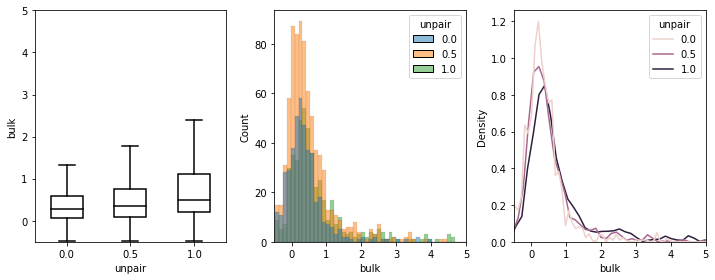

In [155]:
previous = None
boundary_concat_lst = []
out_concat_lst = []
for pos, row in bulk2single_gene_reac_10nt_rRNA_avgreac.sort_index().iterrows():
    if previous == row['unpair']:
        pass
    elif previous != row['unpair']:
        #print (gene, pos)
        try:
            #print (pos)
            out_df = bulk2single_gene_reac_10nt_rRNA_avgreac.loc[[pos-1, pos]]
            out_concat_lst.append(out_df)
        except:
            pass
        previous = row['unpair']
out_df = pd.concat(out_concat_lst)
out_df = out_df.drop_duplicates().sort_index()
out_df['unpair'] = 0.5

bulk2single_gene_reac_10nt_rRNA_avgreac_changeboundary = bulk2single_gene_reac_10nt_rRNA_avgreac.loc[~bulk2single_gene_reac_10nt_rRNA_avgreac.index.isin(out_df.index)]
bulk2single_gene_reac_10nt_rRNA_avgreac_changeboundary = pd.concat([bulk2single_gene_reac_10nt_rRNA_avgreac_changeboundary, out_df]).sort_index()
bulk2single_gene_reac_10nt_rRNA_avgreac_changeboundary

fig, axs = plt.subplots(1,3, figsize=(10,4))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

ax = axs[0]
sns.boxplot(data=bulk2single_gene_reac_10nt_rRNA_avgreac_changeboundary, x="unpair", y="bulk", showfliers=True, color='white', width=.5, fliersize=0, ax=ax, **PROPS)
#plt.setp(ax.artists, edgecolor = 'black', facecolor='w')
#plt.setp(ax.lines, color='black')
ax.set_ylim(-0.5,5)

ax = axs[1]
#sns.histplot(data=tetra_df,x="in_vivo")
sns.histplot(data=bulk2single_gene_reac_10nt_rRNA_avgreac_changeboundary, x="bulk", hue="unpair", common_norm=False, ax=ax, palette="tab10")
ax.set_xlim(-0.5,5)

ax = axs[2]
sns.kdeplot(data=bulk2single_gene_reac_10nt_rRNA_avgreac_changeboundary, x="bulk", hue="unpair", common_norm=False, ax=ax, bw_adjust=0.1)
ax.set_xlim(-0.5,5)
plt.tight_layout()
#plt.savefig("Accuracy_by_Unpaired.Tetrahymena.mark_boundary.boxplot.density.pdf")
plt.show()

## Supplementals

In [ ]:
## read mutant rate matrix in 1-nt resolution
bulk2single_mutrate_1nt = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/batch_1.h9.bulk2single.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
bulk2single_mutrate_1nt_rRNA = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/batch_1.h9.bulk2single.mutrate.1nt.rRNA.csv", header=[0,1,2,3,4], index_col=[0,1])
## remove techniqual replicates
bulk2single_mutrate_1nt = bulk2single_mutrate_1nt.loc[:,~bulk2single_mutrate_1nt.columns.get_level_values('id').isin(['RHE1603','RHE1652','RHE1602','RHE1586','RHE1615','RHE1653','RHE1585','RHE1612','RHE1613'])]
bulk2single_mutrate_1nt = bulk2single_mutrate_1nt.loc[~bulk2single_mutrate_1nt.index.get_level_values('gene').isin(['human_small','human_large'])]

## using the correct rRNA_mutrate_matrix
bulk2single_mutrate_1nt = pd.concat([bulk2single_mutrate_1nt, bulk2single_mutrate_1nt_rRNA], join="inner")

## remove batch_2
bulk2single_mutrate_1nt = bulk2single_mutrate_1nt.xs('batch_1', level='batch', axis=1, drop_level=False)

bulk2single_reac_1nt = iterate_batch_stages_for_reactivity_from_mutrate_matrix(bulk2single_mutrate_1nt)

In [ ]:
bulk2single_reac_1nt.dropna(how="any").groupby(level=['lib_type'], axis=1).mean().corr()

lib_type,bulk,cell_10,cell_100,single
lib_type,,,,
bulk,1.000000,0.439820,0.631331,0.541300
cell_10,0.439820,1.000000,0.441419,0.381728
cell_100,0.631331,0.441419,1.000000,0.530951
single,0.541300,0.381728,0.530951,1.000000


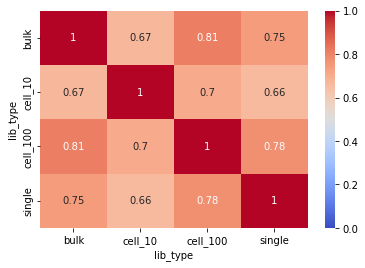

In [ ]:

bulk2single_reac_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(bulk2single_reac_1nt, rolling_wins=10)
bulk2single_reac_rolling_10nt = remove_first_and_last_100nts_of_each_gene(bulk2single_reac_rolling_10nt, left_trim=50, right_trim=50)
bulk2single_reac_rolling_10nt = bulk2single_reac_rolling_10nt.dropna(how="any")

bulk_avg_reac = bulk2single_reac_rolling_10nt .groupby(level=['lib_type'], axis=1).mean()
top100_avg_reac = select_top100_reac(expr_df_h9, bulk_avg_reac)

top100_avg_reac

sns.heatmap(top100_avg_reac.dropna().corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True)
plt.show()

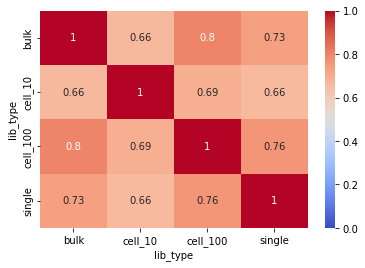

In [156]:
bulk2single_reac_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(bulk2single_reac_1nt, rolling_wins=10)
bulk2single_reac_rolling_10nt = remove_first_and_last_100nts_of_each_gene(bulk2single_reac_rolling_10nt, left_trim=50, right_trim=50)


bulk_avg_reac = bulk2single_reac_rolling_10nt .groupby(level=['lib_type'], axis=1).mean()
top100_avg_reac = select_top100_reac(expr_df_h9, bulk_avg_reac)

top100_avg_reac = gene_normalization_1nt(top100_avg_reac)

sns.heatmap(top100_avg_reac.dropna().corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True)
plt.show()

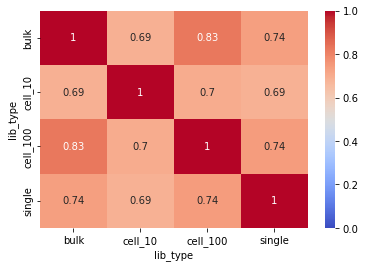

In [206]:
bulk2single_reac_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(bulk2single_reac_1nt, rolling_wins=10)
bulk2single_reac_rolling_10nt = remove_first_and_last_100nts_of_each_gene(bulk2single_reac_rolling_10nt, left_trim=50, right_trim=50)
bulk2single_reac_rolling_10nt = bulk2single_reac_rolling_10nt.dropna(how="any")

#bulk2single_gene_reac_1nt = gene_normalization_1nt(bulk2single_reac_1nt, bottom_winsorize=0.05, top_winsorize=0.01, gene_winsorize=True)
bulk2single_gene_reac_10nt = gene_normalization_1nt(bulk2single_reac_rolling_10nt, bottom_winsorize=0.05, top_winsorize=0.00, gene_winsorize=True)


#bulk2single_reac_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(bulk2single_gene_reac_1nt, rolling_wins=10)
bulk2single_gene_reac_10nt = bulk2single_gene_reac_10nt.dropna(how="any")

bulk_avg_reac = bulk2single_gene_reac_10nt.groupby(level=['lib_type'], axis=1).mean()
top100_avg_reac = select_top100_reac(expr_df_h9, bulk_avg_reac)

sns.heatmap(top100_avg_reac.dropna().corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True)
plt.show()

OAZ1        163
ATP5F1B     171
ATP5ME      204
H2AZ1       242
RPS4X       243
           ... 
TPI1       1082
RPL3       1106
GAPDH      1186
ACTB       1222
EEF1A1     1423
Name: gene, Length: 100, dtype: int64

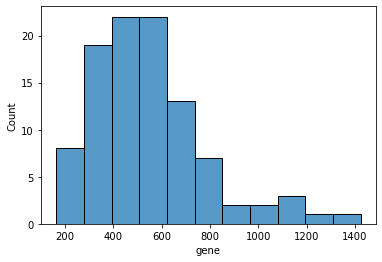

In [202]:
sns.histplot(top100_avg_reac.index.get_level_values('gene').value_counts())
top100_avg_reac.index.get_level_values('gene').value_counts().sort_values()

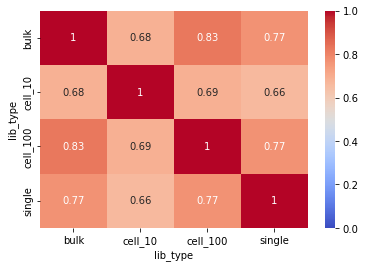

In [196]:
bulk2single_reac_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(bulk2single_reac_1nt, rolling_wins=10)
bulk2single_reac_rolling_10nt = remove_first_and_last_100nts_of_each_gene(bulk2single_reac_rolling_10nt, left_trim=50, right_trim=50)

bulk2single_reac_rolling_10nt = bulk2single_reac_rolling_10nt.dropna(how="any")

bulk_avg_reac = bulk2single_reac_rolling_10nt .groupby(level=['lib_type'], axis=1).mean()
top100_avg_reac = select_top100_reac(expr_df_h9, bulk_avg_reac)

#bulk2single_gene_reac_1nt = gene_normalization_1nt(bulk2single_reac_1nt, bottom_winsorize=0.05, top_winsorize=0.01, gene_winsorize=True)
top100_avg_gnorm_reac = gene_normalization_1nt(top100_avg_reac, bottom_winsorize=0.05, top_winsorize=0.00, gene_winsorize=True)

sns.heatmap(top100_avg_gnorm_reac.dropna().corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True)
plt.show()

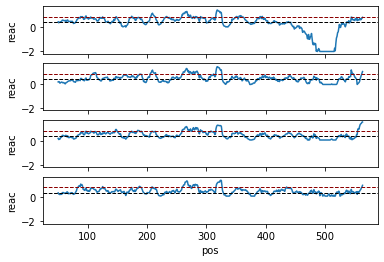

In [181]:
top100_avg_reac.index.get_level_values('gene').unique()

Index(['ACTB', 'ACTG1', 'ATP5F1B', 'ATP5ME', 'COX7C', 'COX8A', 'EEF1A1',
       'ENO1', 'FAU', 'FTH1', 'FTL', 'GAPDH', 'GSTP1', 'H2AZ1', 'H3-3A',
       'H4C3', 'HSP90AB1', 'LDHB', 'MIF', 'MT-ATP6', 'MT-CO1', 'MT-CO2',
       'MT-CO3', 'MT-CYB', 'MT-ND1', 'MT-ND2', 'MT-ND4', 'MTRNR2L12', 'NDUFS5',
       'NPM1', 'OAZ1', 'PFN1', 'PPIA', 'PSMB6', 'RACK1', 'RPL10', 'RPL10A',
       'RPL11', 'RPL12', 'RPL13', 'RPL13A', 'RPL15', 'RPL18', 'RPL18A',
       'RPL19', 'RPL21', 'RPL23A', 'RPL24', 'RPL26', 'RPL27', 'RPL28', 'RPL29',
       'RPL3', 'RPL30', 'RPL31', 'RPL32', 'RPL34', 'RPL35', 'RPL35A', 'RPL36',
       'RPL38', 'RPL39', 'RPL4', 'RPL41', 'RPL5', 'RPL6', 'RPL7', 'RPL7A',
       'RPL8', 'RPL9', 'RPLP0', 'RPLP1', 'RPLP2', 'RPS11', 'RPS12', 'RPS13',
       'RPS15', 'RPS16', 'RPS18', 'RPS19', 'RPS2', 'RPS25', 'RPS27', 'RPS27A',
       'RPS3', 'RPS3A', 'RPS4X', 'RPS5', 'RPS6', 'RPS7', 'RPS8', 'RPS9',
       'RPSA', 'SET', 'SLC25A6', 'TMSB10', 'TMSB4X', 'TPI1', 'TUBA1B', 'TUBB'],
      dtyp

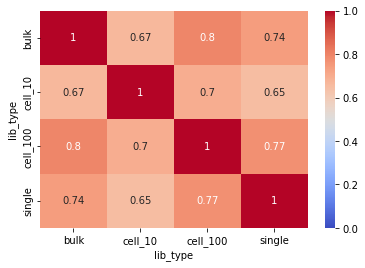

In [132]:


from sklearn.preprocessing import MinMaxScaler
scalor = MinMaxScaler().fit(bulk2single_reac_rolling_10nt )
scaled_bulk_reac = scalor.transform(bulk2single_reac_rolling_10nt)
scaled_bulk_reac = pd.DataFrame(scaled_bulk_reac, index=bulk_reac.index, columns=bulk_reac.columns)

#scaled_bulk_reac = scaled_bulk_reac.dropna(how="all")
scaled_bulk_reac = scaled_bulk_reac.dropna(how="any")

#print (scaled_bulk_reac)

bulk_avg_reac = scaled_bulk_reac.groupby(level=['lib_type'], axis=1).mean()
#bulk_avg_gnorm_reac = gene_normalization_1nt(bulk_avg_reac, bottom_winsorize=0.05, top_winsorize=0.01, gene_winsorize=True)
top100_avg_reac = select_top100_reac(expr_df_h9, bulk_avg_reac)
top100_avg_reac

sns.heatmap(top100_avg_reac.corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True)
plt.show()

In [129]:
bulk_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/batch_1.h9.bulk2single.mutrate.1nt.csv",
                                        header=[0,1,2,3,4], index_col=[0,1])
bulk_mutrate = bulk_mutrate.loc[:,~bulk_mutrate.columns.get_level_values('id').isin(['RHE1603','RHE1652','RHE1602','RHE1586','RHE1615','RHE1653','RHE1585','RHE1612','RHE1613'])]
bulk_mutrate = bulk_mutrate.loc[~bulk_mutrate.index.get_level_values('gene').isin(['human_small','human_large'])]

#mod_bulk_reac = calculate_reactivity_from_mutrate_subtract_to_same_DMSO(bulk_mutrate, dmso_lib_type="bulk")
mod_bulk_reac = iterate_batch_stages_for_reactivity_from_mutrate_matrix(bulk_mutrate)


crude_reac_array = mod_bulk_reac.to_numpy()
#crude_reac_array = winsorize(crude_reac_array, limits=[0.05, 0.05], axis=0, nan_policy="omit")
winsorized_reac = pd.DataFrame(crude_reac_array, index=mod_bulk_reac.index, columns=mod_bulk_reac.columns)
#bulk_reac = remove_first_and_last_100nts_of_each_gene(winsorized_reac, left_trim=100, right_trim=100)
bulk_reac = winsorized_reac
bulk_reac = smooth_by_avg_reac_of_rolling_wins(bulk_reac, rolling_wins=10)

from sklearn.preprocessing import MinMaxScaler
scalor = MinMaxScaler().fit(bulk_reac)
scaled_bulk_reac = scalor.transform(bulk_reac)
scaled_bulk_reac = pd.DataFrame(scaled_bulk_reac, index=bulk_reac.index, columns=bulk_reac.columns)

#scaled_bulk_reac = scaled_bulk_reac.dropna(how="all")
scaled_bulk_reac = scaled_bulk_reac.dropna(how="any")

#print (scaled_bulk_reac)

bulk_avg_reac = scaled_bulk_reac.groupby(level=['lib_type'], axis=1).mean()
#bulk_avg_gnorm_reac = gene_normalization_1nt(bulk_avg_reac, bottom_winsorize=0.05, top_winsorize=0.01, gene_winsorize=True)
top100_avg_reac = select_top100_reac(expr_df_h9, bulk_avg_reac)
top100_avg_reac

sns.heatmap(top100_avg_reac.corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True)
plt.show()

id                 RHE1566   RHE1572   RHE1547   RHE1553   RHE1559   RHE1536  \
batch              batch_1   batch_1   batch_1   batch_1   batch_1   batch_1   
stage                   h9        h9        h9        h9        h9        h9   
lib_type              bulk      bulk   cell_10   cell_10   cell_10  cell_100   
gene        pos                                                                
A1BG        1401 -0.006580  0.005612  0.016736  0.000000  0.028340  0.018519   
            1402  0.002485  0.005481 -0.008772 -0.008772  0.007422  0.013889   
            1403 -0.005680 -0.007657 -0.031317 -0.032620 -0.032102 -0.002282   
            1404 -0.002907  0.002558 -0.008929 -0.008929  0.003267  0.028302   
            1405 -0.002719 -0.005255 -0.013393 -0.017857 -0.005199  0.009390   
...                    ...       ...       ...       ...       ...       ...   
human_small 1866  0.018940  0.016715  0.042478  0.027788  0.012933  0.027479   
            1867 -0.026107 -0.048605  0.020885  0.009286  0.008611 -0.028868   
            1868 -0.138479 -0.128298 -0.130116 -0.162933 -0.121248 -0.091496   
            1869 -0.145812 -0.150118 -0.086813 -0.108139 -0.092817 -0.110977   
            1870 -0.009851  0.012229  0.015145  0.036069  0.042168  0.040634   

id                 RHE1542   RHE1548   RHE1552   RHE1558  ...   RHE1655  \
batch              batch_1   batch_1   batch_1   batch_1  ...   batch_1   
stage                   h9        h9        h9        h9  ...        h9   
lib_type          cell_100  cell_100    single    single  ...    single   
gene        pos                                           ...             
A1BG        1401  0.020725  0.000000       NaN -0.003749  ...       NaN   
            1402  0.000000  0.000000       NaN -0.021418  ...       NaN   
            1403 -0.011628 -0.011628       NaN  0.039267  ...       NaN   
            1404  0.000000  0.000000       NaN  0.009839  ...       NaN   
            1405  0.000000  0.000000       NaN -0.013863  ...       NaN   
...                    ...       ...       ...       ...  ...       ...   
human_small 1866 -0.035833  0.016824 -0.056903  0.003319  ... -0.168583   
            1867 -0.017822 -0.057756 -0.007569 -0.020917  ...  0.120748   
            1868 -0.090938 -0.155158 -0.169498 -0.195771  ... -0.011860   
            1869 -0.073224 -0.163685 -0.111214 -0.180316  ...  0.100022   
            1870  0.025156  0.046464  0.049771  0.065828  ... -0.231822   

id                 RHE1585   RHE1586   RHE1602   RHE1603   RHE1612   RHE1613  \
batch              batch_1   batch_1   batch_1   batch_1   batch_1   batch_1   
stage                   h9        h9        h9        h9        h9        h9   
lib_type            single    single    single    single    single    single   
gene        pos                                                                
A1BG        1401       NaN       NaN       NaN       NaN       NaN       NaN   
            1402       NaN       NaN       NaN       NaN       NaN       NaN   
            1403       NaN       NaN       NaN       NaN       NaN       NaN   
            1404       NaN       NaN       NaN       NaN       NaN       NaN   
            1405       NaN       NaN       NaN       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
human_small 1866 -0.055759 -0.019165 -0.004230 -0.104459 -0.054938 -0.081548   
            1867  0.006011 -0.025408 -0.045938  0.046274  0.009447  0.023902   
            1868 -0.083442 -0.030983 -0.167839 -0.088938 -0.143953 -0.091049   
            1869 -0.034878 -0.030916 -0.160652  0.029455 -0.067002 -0.046005   
            1870 -0.026010  0.029475  0.029110       NaN  0.032343  0.031165   

id                 RHE1615   RHE1652   RHE1653  
batch              batch_1   batch_1   batch_1  
stage                   h9        h9        h9  
lib_type            single    single    single  
gene        pos                          

### 1.1 transcriptome scaling

In [35]:
## transcriptome-wide winsorization

## normalization first then calculate the average then
bottom_winsorize = 0.05
top_winsorize = 0.01
crude_reac_array = bulk2single_reac_1nt.to_numpy()
crude_reac_array = winsorize(crude_reac_array, limits=[bottom_winsorize, top_winsorize], axis=0, nan_policy="omit")
winsorized_reac = pd.DataFrame(crude_reac_array, index=bulk2single_reac_1nt.index, columns=bulk2single_reac_1nt.columns)
## smoothing by rolling 10-nt
bulk2single_reac_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(winsorized_reac, rolling_wins=10)
## remove the terminal nts
bulk2single_reac_rolling_10nt = remove_first_and_last_100nts_of_each_gene(bulk2single_reac_rolling_10nt, left_trim=50, right_trim=50)


from sklearn.preprocessing import MinMaxScaler
scalor = MinMaxScaler().fit(bulk2single_reac_rolling_10nt)
scaled_bulk2single_reac_10nt = scalor.transform(bulk2single_reac_rolling_10nt)
scaled_bulk2single_reac_10nt = pd.DataFrame(scaled_bulk2single_reac_10nt, index=bulk2single_reac_rolling_10nt.index, columns=bulk2single_reac_rolling_10nt.columns)
scaled_bulk2single_reac_10nt = scaled_bulk2single_reac_10nt.dropna(how="all")
scaled_bulk2single_reac_10nt

## average mutant rate first then normalize 
bulk2single_reac_1nt


KeyboardInterrupt



In [45]:
## average mutant rate first then normalize 
bulk2single_avg_reac_1nt = bulk2single_reac_1nt.groupby(level="lib_type", axis=1).mean()
bulk2single_avg_reac_1nt 

## winsorization
bottom_winsorize = 0.05
top_winsorize = 0.0
crude_reac_array = bulk2single_avg_reac_1nt.to_numpy()
crude_reac_array = winsorize(crude_reac_array, limits=[bottom_winsorize, top_winsorize], axis=0, nan_policy="omit")
winsorized_avg_reac = pd.DataFrame(crude_reac_array, index=bulk2single_avg_reac_1nt.index, columns=bulk2single_avg_reac_1nt.columns)
## smoothing by rolling 10-nt
bulk2single_avg_reac_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(winsorized_avg_reac, rolling_wins=10)
## remove the terminal nts
bulk2single_avg_reac_rolling_10nt = remove_first_and_last_100nts_of_each_gene(bulk2single_avg_reac_rolling_10nt, left_trim=50, right_trim=50)

from sklearn.preprocessing import MinMaxScaler
scalor = MinMaxScaler().fit(bulk2single_avg_reac_rolling_10nt)
scaled_bulk2single_avg_reac_10nt = scalor.transform(bulk2single_avg_reac_rolling_10nt)
scaled_bulk2single_avg_reac_10nt = pd.DataFrame(scaled_bulk2single_avg_reac_10nt, index=bulk2single_avg_reac_rolling_10nt.index, columns=bulk2single_avg_reac_rolling_10nt.columns)
scaled_bulk2single_avg_reac_10nt = scaled_bulk2single_avg_reac_10nt.dropna(how="all")
scaled_bulk2single_avg_reac_10nt


lib_type              bulk   cell_10  cell_100    single
gene        pos                                         
A1BG        1406  0.180072  0.066156  0.232411  0.158228
            1407  0.218335  0.054878  0.201399  0.155674
            1408  0.222373  0.049593  0.195570  0.156263
            1411  0.239700  0.057255  0.230264  0.152188
            1412  0.231179  0.052455  0.212698  0.153337
...                    ...       ...       ...       ...
human_small 1816  0.268864  0.054418  0.194950  0.191163
            1817  0.279510  0.055134  0.200013  0.195659
            1818  0.291173  0.054721  0.205644  0.204752
            1819  0.304707  0.056073  0.210759  0.208027
            1820  0.307840  0.055216  0.208879  0.207305

[1180711 rows x 4 columns]

bulk
cell_10
cell_100
single


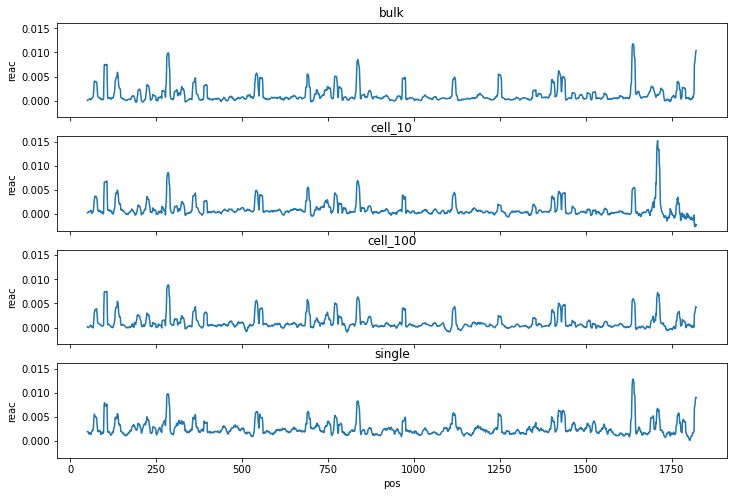

In [47]:
#rRNA_avg_reac = scaled_bulk2single_avg_reac_10nt.loc[scaled_bulk2single_avg_reac_10nt.index.get_level_values('gene')=="human_small"]
rRNA_avg_reac = bulk2single_avg_reac_rolling_10nt.loc[bulk2single_avg_reac_rolling_10nt.index.get_level_values('gene')=="human_small"]


stacked_rRNA_avg_reac = rRNA_avg_reac.stack().to_frame('reac').reset_index()
stacked_rRNA_avg_reac

n = 0
fig, axs = plt.subplots(4,1, figsize=(12,8), sharex=True, sharey=True)
for libtype, subset in stacked_rRNA_avg_reac.groupby('lib_type'):
    print (libtype)
    ax = axs[n]
    sns.lineplot(data=subset, x="pos", y="reac", ax=ax)
    ax.set_title(libtype)
    n += 1
plt.show()

In [48]:
rRNA_avg_reac.corr()

lib_type,bulk,cell_10,cell_100,single
lib_type,,,,
bulk,1.000000,0.681606,0.883426,0.914354
cell_10,0.681606,1.000000,0.887714,0.737933
cell_100,0.883426,0.887714,1.000000,0.864777
single,0.914354,0.737933,0.864777,1.000000


In [29]:
scaled_bulk2single_reac_10nt.describe()

id,RHE1566,RHE1572,RHE1547,RHE1553,RHE1559,RHE1536,RHE1542,RHE1548,RHE1552,RHE1558,...,RHS3587,RHS3588,RHS3589,RHS3590,RHS3591,RHS3592,RHS3593,RHS3594,RHS3595,RHS3596
batch,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,...,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2
stage,h9,h9,h9,h9,h9,h9,h9,h9,h9,h9,...,h9,h9,h9,h9,h9,h9,h9,h9,h9,h9
lib_type,bulk,bulk,cell_10,cell_10,cell_10,cell_100,cell_100,cell_100,single,single,...,single,single,single,single,single,single,single,single,single,single
count,1.178168e+06,1.179591e+06,1.113502e+06,1.056276e+06,1.098367e+06,1.166843e+06,1.169194e+06,1.170893e+06,807697.000000,825675.000000,...,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000
mean,6.635784e-01,7.332543e-01,3.403252e-01,2.610847e-01,2.710189e-01,4.777732e-01,4.507286e-01,4.969964e-01,0.251606,0.265451,...,0.279123,0.212005,0.213292,0.233278,0.213522,0.246050,0.147813,0.196501,0.188623,0.183202
std,3.239131e-02,2.796480e-02,3.347528e-02,3.314567e-02,3.243736e-02,3.627617e-02,4.612697e-02,4.104876e-02,0.035869,0.040558,...,0.104687,0.107708,0.103514,0.109517,0.109499,0.099258,0.083255,0.083695,0.094232,0.103712
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.428012e-01,7.152442e-01,3.222635e-01,2.459007e-01,2.553877e-01,4.552279e-01,4.222058e-01,4.714403e-01,0.237200,0.249450,...,0.213509,0.141767,0.143554,0.162278,0.149279,0.184338,0.105495,0.146847,0.129704,0.113066
50%,6.610195e-01,7.310544e-01,3.330748e-01,2.527683e-01,2.629646e-01,4.736318e-01,4.457542e-01,4.933087e-01,0.242469,0.255321,...,0.259991,0.188192,0.189697,0.218451,0.190255,0.226088,0.137390,0.182854,0.180304,0.167672
75%,6.819850e-01,7.491502e-01,3.501811e-01,2.652403e-01,2.766688e-01,4.954987e-01,4.732203e-01,5.183957e-01,0.250878,0.264521,...,0.331322,0.258111,0.265202,0.285296,0.252592,0.282640,0.172409,0.229533,0.229621,0.233145


In [93]:
top100_reac_1nt = select_top100_reac(expr_df_h9, bulk2single_reac_1nt)

## average mutant rate first then normalize 
top100_avg_reac_1nt = top100_reac_1nt.groupby(level="lib_type", axis=1).mean()
top100_avg_reac_1nt 

## winsorization
bottom_winsorize = 0.05
top_winsorize = 0.01
crude_reac_array = top100_avg_reac_1nt.to_numpy()
crude_reac_array = winsorize(crude_reac_array, limits=[bottom_winsorize, top_winsorize], axis=0, nan_policy="omit")
winsorized_avg_reac = pd.DataFrame(crude_reac_array, index=top100_avg_reac_1nt.index, columns=top100_avg_reac_1nt.columns)
## smoothing by rolling 10-nt
top100_avg_reac_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(winsorized_avg_reac, rolling_wins=10)
## remove the terminal nts
top100_avg_reac_rolling_10nt = remove_first_and_last_100nts_of_each_gene(top100_avg_reac_rolling_10nt, left_trim=50, right_trim=50)
print (top100_avg_reac_rolling_10nt.corr())

from sklearn.preprocessing import MinMaxScaler
scalor = MinMaxScaler().fit(top100_avg_reac_rolling_10nt)
scaled_top100_avg_reac_10nt = scalor.transform(top100_avg_reac_rolling_10nt)
scaled_top100_avg_reac_10nt = pd.DataFrame(scaled_top100_avg_reac_10nt, index=top100_avg_reac_rolling_10nt.index, columns=top100_avg_reac_rolling_10nt.columns)
scaled_top100_avg_reac_10nt = scaled_top100_avg_reac_10nt.dropna(how="all")
scaled_top100_avg_reac_10nt.corr()

lib_type      bulk   cell_10  cell_100    single
lib_type                                        
bulk      1.000000  0.587592  0.784690  0.644963
cell_10   0.587592  1.000000  0.581013  0.509726
cell_100  0.784690  0.581013  1.000000  0.611392
single    0.644963  0.509726  0.611392  1.000000


lib_type,bulk,cell_10,cell_100,single
lib_type,,,,
bulk,1.000000,0.587592,0.784690,0.644963
cell_10,0.587592,1.000000,0.581013,0.509726
cell_100,0.784690,0.581013,1.000000,0.611392
single,0.644963,0.509726,0.611392,1.000000


In [96]:
## transcriptome-wide winsorization

## normalization first then calculate the average then
bottom_winsorize = 0
top_winsorize = 0
crude_reac_array = bulk2single_reac_1nt.to_numpy()
crude_reac_array = winsorize(crude_reac_array, limits=[bottom_winsorize, top_winsorize], axis=0, nan_policy="omit")
winsorized_reac = pd.DataFrame(crude_reac_array, index=bulk2single_reac_1nt.index, columns=bulk2single_reac_1nt.columns)
## smoothing by rolling 10-nt
bulk2single_reac_rolling_10nt = smooth_by_avg_reac_of_rolling_wins(winsorized_reac, rolling_wins=10)
## remove the terminal nts
#bulk2single_reac_rolling_10nt = remove_first_and_last_100nts_of_each_gene(bulk2single_reac_rolling_10nt, left_trim=50, right_trim=50)


from sklearn.preprocessing import MinMaxScaler
scalor = MinMaxScaler().fit(bulk2single_reac_rolling_10nt)
scaled_bulk2single_reac_10nt = scalor.transform(bulk2single_reac_rolling_10nt)
scaled_bulk2single_reac_10nt = pd.DataFrame(scaled_bulk2single_reac_10nt, index=bulk2single_reac_rolling_10nt.index, columns=bulk2single_reac_rolling_10nt.columns)
scaled_bulk2single_reac_10nt = scaled_bulk2single_reac_10nt.dropna(how="all")
scaled_bulk2single_reac_10nt


top100_reac_10nt = select_top100_reac(expr_df_h9, scaled_bulk2single_reac_10nt)
top100_avg_reac_10nt = top100_reac_10nt.groupby(level="lib_type", axis=1).mean()
top100_avg_reac_10nt = top100_avg_reac_10nt.dropna()
top100_avg_reac_10nt.corr()

lib_type,bulk,cell_10,cell_100,single
lib_type,,,,
bulk,1.000000,0.549294,0.747503,0.537218
cell_10,0.549294,1.000000,0.548368,0.404242
cell_100,0.747503,0.548368,1.000000,0.521797
single,0.537218,0.404242,0.521797,1.000000


In [95]:
scaled_bulk2single_reac_10nt

id                 RHE1566   RHE1572   RHE1547   RHE1553   RHE1559   RHE1536  \
batch              batch_1   batch_1   batch_1   batch_1   batch_1   batch_1   
stage                   h9        h9        h9        h9        h9        h9   
lib_type              bulk      bulk   cell_10   cell_10   cell_10  cell_100   
gene        pos                                                                
human_small 7     0.556693  0.623321  0.270603  0.246443  0.257431  0.448595   
            8     0.558451  0.623942  0.271126  0.247569  0.259300  0.450021   
            9     0.557320  0.622517  0.271228  0.247907  0.260382  0.450967   
            10    0.560534  0.624195  0.272634  0.249886  0.261514  0.453102   
            11    0.561503  0.624507  0.273261  0.250821  0.262224  0.452609   
...                    ...       ...       ...       ...       ...       ...   
            1840  0.584943  0.648593  0.269730  0.245091  0.258094  0.476216   
            1841  0.578517  0.641939  0.270138  0.244901  0.255862  0.468674   
            1842  0.573602  0.636834  0.271412  0.246135  0.258601  0.463276   
            1843  0.570211  0.632842  0.273315  0.244371  0.255395  0.461760   
            1844  0.570701  0.632833  0.270050  0.245710  0.250209  0.465873   

id                 RHE1542   RHE1548   RHE1552   RHE1558  ...   RHS3587  \
batch              batch_1   batch_1   batch_1   batch_1  ...   batch_2   
stage                   h9        h9        h9        h9  ...        h9   
lib_type          cell_100  cell_100    single    single  ...    single   
gene        pos                                           ...             
human_small 7     0.395844  0.473872  0.244466  0.259874  ...  0.608420   
            8     0.399923  0.470166  0.243171  0.258939  ...  0.640760   
            9     0.402970  0.466036  0.242958  0.257592  ...  0.666662   
            10    0.408292  0.466058  0.243990  0.257164  ...  0.643624   
            11    0.407670  0.464053  0.244455  0.257964  ...  0.647519   
...                    ...       ...       ...       ...  ...       ...   
            1840  0.419333  0.497169  0.237550  0.259871  ...  0.594209   
            1841  0.413664  0.490487  0.236489  0.259705  ...  0.580688   
            1842  0.406778  0.482667  0.233718  0.259634  ...  0.593384   
            1843  0.411170  0.477752  0.232239  0.258267  ...  0.632270   
            1844  0.418638  0.478666  0.234563  0.266730  ...  0.676012   

id                 RHS3588   RHS3589   RHS3590   RHS3591   RHS3592   RHS3593  \
batch              batch_2   batch_2   batch_2   batch_2   batch_2   batch_2   
stage                   h9        h9        h9        h9        h9        h9   
lib_type            single    single    single    single    single    single   
gene        pos                                                                
human_small 7     0.720022  0.584307  0.520882  0.698396  0.601010  0.633737   
            8     0.746667  0.603404  0.555837  0.722390  0.619591  0.650720   
            9     0.762138  0.623384  0.580460  0.740324  0.634719  0.668630   
            10    0.755460  0.625733  0.568226  0.724985  0.624664  0.652818   
            11    0.758455  0.636587  0.569819  0.725151  0.630002  0.652458   
...                    ...       ...       ...       ...       ...       ...   
            1840  0.737238  0.634500  0.586399  0.818981  0.727780  0.664513   
            1841  0.722774  0.617061  0.559714  0.806968  0.690991  0.642957   
            1842  0.727198  0.615548  0.555839  0.790374  0.656918  0.645821   
            1843  0.713312  0.587017  0.569990  0.800775  0.634097  0.686544   
            1844  0.780778  0.635112  0.565465  0.810448  0.570567  0.727870   

id                 RHS3594   RHS3595   RHS3596  
batch              batch_2   batch_2   batch_2  
stage                   h9        h9        h9  
lib_type            single    single    single  
gene        pos                          

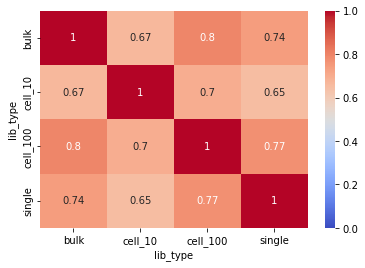

In [102]:
bulk_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/batch_1.h9.bulk2single.mutrate.1nt.csv",
                                        header=[0,1,2,3,4], index_col=[0,1])
bulk_mutrate = bulk_mutrate.loc[:,~bulk_mutrate.columns.get_level_values('id').isin(['RHE1603','RHE1652','RHE1602','RHE1586','RHE1615','RHE1653','RHE1585','RHE1612','RHE1613'])]
bulk_mutrate = bulk_mutrate.loc[~bulk_mutrate.index.get_level_values('gene').isin(['human_small','human_large'])]

#mod_bulk_reac = calculate_reactivity_from_mutrate_subtract_to_same_DMSO(bulk_mutrate, dmso_lib_type="bulk")
mod_bulk_reac = iterate_batch_stages_for_reactivity_from_mutrate_matrix(bulk_mutrate)


crude_reac_array = mod_bulk_reac.to_numpy()
#crude_reac_array = winsorize(crude_reac_array, limits=[0.05, 0.05], axis=0, nan_policy="omit")
winsorized_reac = pd.DataFrame(crude_reac_array, index=mod_bulk_reac.index, columns=mod_bulk_reac.columns)
#bulk_reac = remove_first_and_last_100nts_of_each_gene(winsorized_reac, left_trim=100, right_trim=100)
bulk_reac = winsorized_reac
bulk_reac = smooth_by_avg_reac_of_rolling_wins(bulk_reac, rolling_wins=10)

from sklearn.preprocessing import MinMaxScaler
scalor = MinMaxScaler().fit(bulk_reac)
scaled_bulk_reac = scalor.transform(bulk_reac)
scaled_bulk_reac = pd.DataFrame(scaled_bulk_reac, index=bulk_reac.index, columns=bulk_reac.columns)

#scaled_bulk_reac = scaled_bulk_reac.dropna(how="all")
scaled_bulk_reac = scaled_bulk_reac.dropna(how="any")

#print (scaled_bulk_reac)

bulk_avg_reac = scaled_bulk_reac.groupby(level=['lib_type'], axis=1).mean()
#bulk_avg_gnorm_reac = gene_normalization_1nt(bulk_avg_reac, bottom_winsorize=0.05, top_winsorize=0.01, gene_winsorize=True)
top100_avg_reac = select_top100_reac(expr_df_h9, bulk_avg_reac)
top100_avg_reac

sns.heatmap(top100_avg_reac.corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True)
plt.show()

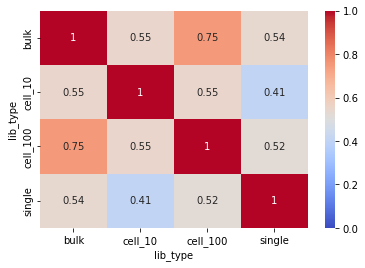

In [123]:
bulk_reac = bulk2single_reac_1nt
bulk_reac = smooth_by_avg_reac_of_rolling_wins(bulk_reac, rolling_wins=10)

from sklearn.preprocessing import MinMaxScaler
scalor = MinMaxScaler().fit(bulk_reac)
scaled_bulk_reac = scalor.transform(bulk_reac)
scaled_bulk_reac = pd.DataFrame(scaled_bulk_reac, index=bulk_reac.index, columns=bulk_reac.columns)

scaled_bulk_reac = scaled_bulk_reac.dropna(how="all")
#scaled_bulk_reac = scaled_bulk_reac.dropna(how="any")

#print (scaled_bulk_reac)

bulk_avg_reac = scaled_bulk_reac.groupby(level=['lib_type'], axis=1).mean()
#bulk_avg_gnorm_reac = gene_normalization_1nt(bulk_avg_reac, bottom_winsorize=0.05, top_winsorize=0.01, gene_winsorize=True)
top100_avg_reac = select_top100_reac(expr_df_h9, bulk_avg_reac)
top100_avg_reac

sns.heatmap(top100_avg_reac.corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True)
plt.show()

In [124]:
bulk_mutrate

id        RHE1534   RHE1535   RHE1536   RHE1540 RHE1541   RHE1542   RHE1546  \
batch     batch_1   batch_1   batch_1   batch_1 batch_1   batch_1   batch_1   
stage          h9        h9        h9        h9      h9        h9        h9   
agent        dmso      dmso    nai-n3      dmso    dmso    nai-n3      dmso   
lib_type   single   cell_10  cell_100    single cell_10  cell_100    single   
gene pos                                                                      
A1BG 1401     NaN  0.000000  0.018519  0.000000     NaN  0.020725  0.000000   
     1402     NaN  0.008772  0.013889  0.008772     NaN  0.000000  0.018519   
     1403     NaN  0.044248  0.009346  0.008696     NaN  0.000000  0.006211   
     1404     NaN  0.008929  0.028302  0.008621     NaN  0.000000  0.006211   
     1405     NaN  0.017857  0.009390  0.017241     NaN  0.000000  0.006211   
...           ...       ...       ...       ...     ...       ...       ...   
ZYX  2153     NaN  0.000000  0.000000  0.018868     NaN  0.000000       NaN   
     2154     NaN       NaN  0.000000  0.000000     NaN  0.000000       NaN   
     2155     NaN       NaN  0.000000  0.000000     NaN  0.000000       NaN   
     2156     NaN       NaN  0.000000  0.020202     NaN  0.033333       NaN   
     2157     NaN       NaN  0.010989  0.000000     NaN  0.000000       NaN   

id          RHE1547   RHE1548 RHE1552  ...   RHE1599 RHE1600   RHE1601  \
batch       batch_1   batch_1 batch_1  ...   batch_1 batch_1   batch_1   
stage            h9        h9      h9  ...        h9      h9        h9   
agent        nai-n3    nai-n3  nai-n3  ...    nai-n3  nai-n3    nai-n3   
lib_type    cell_10  cell_100  single  ...    single  single    single   
gene pos                               ...                               
A1BG 1401  0.016736  0.000000     NaN  ...       NaN     NaN  0.016807   
     1402  0.000000  0.000000     NaN  ...       NaN     NaN  0.000000   
     1403  0.012931  0.000000     NaN  ...       NaN     NaN  0.008403   
     1404  0.000000  0.000000     NaN  ...       NaN     NaN  0.016807   
     1405  0.004464  0.000000     NaN  ...       NaN     NaN  0.105263   
...             ...       ...     ...  ...       ...     ...       ...   
ZYX  2153  0.010101  0.000000     NaN  ...  0.000000     NaN       NaN   
     2154  0.020202  0.000000     NaN  ...  0.000000     NaN       NaN   
     2155  0.000000  0.000000     NaN  ...  0.000000     NaN       NaN   
     2156  0.010204  0.009434     NaN  ...  0.015873     NaN       NaN   
     2157  0.030612  0.000000     NaN  ...       NaN     NaN       NaN   

id          RHE1604   RHE1605   RHE1606 RHE1607   RHE1614 RHE1654 RHE1655  
batch       batch_1   batch_1   batch_1 batch_1   batch_1 batch_1 batch_1  
stage            h9        h9        h9      h9        h9      h9      h9  
agent          dmso      dmso      dmso    dmso    nai-n3  nai-n3  nai-n3  
lib_type     single    single    single  single    single  single  single  
gene pos                                                                   
A1BG 1401  0.011111  0.000000  0.007634     NaN       NaN     NaN     NaN  
     1402  0.055556  0.016667  0.007576     NaN       NaN     NaN     NaN  
     1403  0.000000  0.000000  0.038760     NaN       NaN     NaN     NaN  
     1404  0.011494  0.000000  0.007812     NaN       NaN     NaN     NaN  
     1405  0.000000       NaN  0.032000     NaN       NaN     NaN     NaN  
...             ...       ...       ...     ...       ...     ...     ...  
ZYX  2153       NaN  0.019231  0.019231     NaN  0.000000     NaN     NaN  
     2154       NaN  0.019608  0.000000     NaN  0.000000     NaN     NaN  
     2155       NaN  0.010000  0.039474     NaN  0.021978     NaN     NaN  
     2156       NaN  0.050505  0.033333     NaN  0.000000     NaN     NaN  
     2157       NaN  0.010417  0.020548     NaN  0.000000     NaN     NaN  

[1292854 rows x 52 columns]

In [70]:
bulk_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/batch_1.h9.bulk2single.mutrate.1nt.csv",
                                        header=[0,1,2,3,4], index_col=[0,1])
bulk_mutrate = bulk_mutrate.loc[:,~bulk_mutrate.columns.get_level_values('id').isin(['RHE1603','RHE1652','RHE1602','RHE1586','RHE1615','RHE1653','RHE1585','RHE1612','RHE1613'])]
bulk_mutrate = bulk_mutrate.loc[~bulk_mutrate.index.get_level_values('gene').isin(['human_small','human_large'])]

#mod_bulk_reac = calculate_reactivity_from_mutrate_subtract_to_same_DMSO(bulk_mutrate, dmso_lib_type="bulk")
mod_bulk_reac = iterate_batch_stages_for_reactivity_from_mutrate_matrix(bulk_mutrate)


crude_reac_array = mod_bulk_reac.to_numpy()
#crude_reac_array = winsorize(crude_reac_array, limits=[0.05, 0.05], axis=0, nan_policy="omit")
winsorized_reac = pd.DataFrame(crude_reac_array, index=mod_bulk_reac.index, columns=mod_bulk_reac.columns)
#bulk_reac = remove_first_and_last_100nts_of_each_gene(winsorized_reac, left_trim=100, right_trim=100)
bulk_reac = winsorized_reac
bulk_reac = smooth_by_avg_reac_of_rolling_wins(bulk_reac, rolling_wins=10)

from sklearn.preprocessing import MinMaxScaler
scalor = MinMaxScaler().fit(bulk_reac)
scaled_bulk_reac = scalor.transform(bulk_reac)
scaled_bulk_reac = pd.DataFrame(scaled_bulk_reac, index=bulk_reac.index, columns=bulk_reac.columns)

#scaled_bulk_reac = scaled_bulk_reac.dropna(how="all")
scaled_bulk_reac = scaled_bulk_reac.dropna(how="any")

#print (scaled_bulk_reac)

bulk_avg_reac = scaled_bulk_reac.groupby(level=['lib_type'], axis=1).mean()
#bulk_avg_gnorm_reac = gene_normalization_1nt(bulk_avg_reac, bottom_winsorize=0.05, top_winsorize=0.01, gene_winsorize=True)
top100_avg_reac = select_top100_reac(expr_df_h9, bulk_avg_reac)
top100_avg_reac

sns.heatmap(top100_avg_reac.corr(), cmap="coolwarm", vmax=1, vmin=0, annot=True)
plt.show()

id          RHE1566   RHE1572   RHE1547   RHE1553   RHE1559   RHE1536  \
batch       batch_1   batch_1   batch_1   batch_1   batch_1   batch_1   
stage            h9        h9        h9        h9        h9        h9   
lib_type       bulk      bulk   cell_10   cell_10   cell_10  cell_100   
gene pos                                                                
A1BG 1406  0.561600  0.612824  0.263069  0.255184  0.251109  0.470531   
     1407  0.566745  0.629125  0.253149  0.249953  0.242209  0.455876   
     1408  0.566404  0.631632  0.248238  0.248446  0.228287  0.441549   
     1411  0.573118  0.635106  0.256172  0.252564  0.236667  0.443496   
     1412  0.571769  0.631656  0.252403  0.247448  0.233798  0.423390   
...             ...       ...       ...       ...       ...       ...   
ZYX  2149  0.572386  0.652151  0.277728  0.253374  0.295024       NaN   
     2150  0.579430  0.650693       NaN       NaN       NaN       NaN   
     2151  0.576289  0.656652       NaN       NaN       NaN       NaN   
     2152  0.582138  0.638254       NaN       NaN       NaN       NaN   
     2153  0.584257  0.621867       NaN       NaN       NaN       NaN   

id          RHE1542   RHE1548 RHE1552   RHE1558  ... RHE1595   RHE1596  \
batch       batch_1   batch_1 batch_1   batch_1  ... batch_1   batch_1   
stage            h9        h9      h9        h9  ...      h9        h9   
lib_type   cell_100  cell_100  single    single  ...  single    single   
gene pos                                         ...                     
A1BG 1406  0.417745  0.440832     NaN  0.256230  ...     NaN       NaN   
     1407  0.381517  0.417912     NaN  0.264512  ...     NaN       NaN   
     1408  0.380173  0.428614     NaN  0.272217  ...     NaN       NaN   
     1411  0.388626  0.467615     NaN  0.266265  ...     NaN       NaN   
     1412  0.368509  0.487122     NaN  0.267766  ...     NaN       NaN   
...             ...       ...     ...       ...  ...     ...       ...   
ZYX  2149       NaN       NaN     NaN  0.228793  ...     NaN  0.280330   
     2150       NaN       NaN     NaN  0.234902  ...     NaN  0.288173   
     2151       NaN       NaN     NaN  0.231634  ...     NaN  0.282903   
     2152       NaN       NaN     NaN  0.230558  ...     NaN  0.277536   
     2153       NaN       NaN     NaN  0.237194  ...     NaN  0.274672   

id        RHE1597   RHE1598   RHE1599 RHE1600   RHE1601   RHE1614 RHE1654  \
batch     batch_1   batch_1   batch_1 batch_1   batch_1   batch_1 batch_1   
stage          h9        h9        h9      h9        h9        h9      h9   
lib_type   single    single    single  single    single    single  single   
gene pos                                                                    
A1BG 1406     NaN       NaN       NaN     NaN  0.411607       NaN     NaN   
     1407     NaN       NaN       NaN     NaN  0.408758       NaN     NaN   
     1408     NaN       NaN       NaN     NaN  0.412185       NaN     NaN   
     1411     NaN       NaN       NaN     NaN  0.413369       NaN     NaN   
     1412     NaN       NaN       NaN     NaN  0.411423       NaN     NaN   
...           ...       ...       ...     ...       ...       ...     ...   
ZYX  2149     NaN  0.357020  0.238040     NaN       NaN  0.246457     NaN   
     2150     NaN  0.370824  0.247936     NaN       NaN  0.255996     NaN   
     2151     NaN  0.372972  0.246294     NaN       NaN  0.255503     NaN   
     2152     NaN  0.381001  0.245052     NaN       NaN  0.254826     NaN   
     2153     NaN  0.395044       NaN     NaN       NaN  0.256852     NaN   

id        RHE1655  
batch     batch_1  
stage          h9  
lib_type   single  
gene pos           
A1BG 1406     NaN  
     1407     NaN  
     1408     NaN  
     1411     NaN  
     1412     NaN  
...           ...  
ZYX  2149     NaN  
     2150     NaN  
     2151     NaN  
     2152     NaN  
     2153     NaN  

[1258463 rows x 39 columns]

In [17]:
b1_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.h9.mutrate.1nt.csv",
                                        header=[0,1,2,3,4], index_col=[0,1])
b2_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.h9.mutrate.1nt.csv",
                                        header=[0,1,2,3,4], index_col=[0,1])
mutrate_df = pd.concat([b1_mutrate, b2_mutrate], axis=1)
col_df = mutrate_df.columns.to_frame()
col_df.index = list(range(col_df.index.size))
col_df[['stage', 'agent','lib_type']].value_counts()

stage  agent   lib_type
h9     nai-n3  single      76
       dmso    single      11
dtype: int64

lib_type,bulk,cell_10,cell_100,single
lib_type,,,,
bulk,1.000000,0.549655,0.747326,0.537154
cell_10,0.549655,1.000000,0.548387,0.405745
cell_100,0.747326,0.548387,1.000000,0.521670
single,0.537154,0.405745,0.521670,1.000000


In [ ]:
top100_avg_reac.index.get_level_values('gene').value_counts().sort_values()

OAZ1        163
ATP5F1B     189
RPS4X       243
H2AZ1       245
MT-ND4L     260
           ... 
TPI1       1082
RPL3       1142
ACTB       1222
GAPDH      1273
EEF1A1     1423
Name: gene, Length: 100, dtype: int64

In [ ]:
top100_avg_reac_10nt.index.get_level_values('gene').value_counts().sort_values()

MT-ATP8      193
MT-ND4L      287
ATP5ME       292
RPL38        317
RPS27        336
            ... 
ENO1        1769
ACTG1       1884
HSP90AB1    2453
TUBB        2457
SET         2514
Name: gene, Length: 100, dtype: int64